In [1]:
import os
import json
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix
from scipy.interpolate import interp1d
from scipy.spatial import distance
from tqdm import tqdm
from itertools import product, chain

In [2]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# 랜드마크 인덱스 정의 # 11개
LANDMARKS = [0, 11, 12, 15, 16, 23, 24, 25, 26, 27, 28]
FRAME_INTERVAL = 6
VID_LEN = 600
FRAMES = list(range(0, VID_LEN, FRAME_INTERVAL))
CLASS_LIST = ['Normal', 'Danger', 'Fall']
DR = 'E'
pt_path = DR + r':\project\CVProject\results\result_pt_JKH'
train_size, valid_size, test_size = 0.8, 0.1, 0.1

In [7]:
def fill_missing_data(data):
    frame_exist_list = [int(x.split('_')[-1]) for x in data['pose_data']]
    key_list = list(map(lambda x: CLASS_LIST.index(x['class']), data['pose_data'].values()))
    pose_list = list(map(lambda x: list(chain(*[list(v.values()) for k, v in x.items() if 'landmark' in k])), data['pose_data'].values()))
    bbox_list = list(map(lambda x: list(chain(*[list(v.values()) for k, v in x.items() if k == 'bbox'])), data['pose_data'].values()))

    key = list(interp1d(frame_exist_list, key_list, kind='nearest-up', fill_value='extrapolate')(FRAMES))
    pose = list(interp1d(frame_exist_list, pose_list, kind='linear', fill_value='extrapolate', axis=0)(FRAMES))
    bbox = list(interp1d(frame_exist_list, bbox_list, kind='linear', fill_value='extrapolate', axis=0)(FRAMES))

    new_data = {
        f'frame_{i}': {
            f'landmark_{k}': {
                'x': pose[idx_i][2*idx_k+0],
                'y': pose[idx_i][2*idx_k+1],
            } for idx_k, k in enumerate(LANDMARKS)
        } for idx_i, i in enumerate(FRAMES)
    }
    for idx_i, i in enumerate(FRAMES):
        new_data[f'frame_{i}'].update({'bbox':{'x1': bbox[idx_i][0], 'y1': bbox[idx_i][1], 'x2': bbox[idx_i][2], 'y2': bbox[idx_i][3]}, 
                                       'class': CLASS_LIST[int(key[idx_i])]})
    return new_data

In [8]:
# 바운딩 박스 비율 클래스 정의 함수
def bbox_ratio_class(ratio):
    if ratio < 0.7:
        return 0  # Normal 가능성 높은 class
    else:
        return 1  # Danger or Fall 가능성 높은 class

# YOLO xy 비율 계산 함수
def calculate_yolo_xy_ratio(frame):
    bbox = frame.get('bbox', None)
    if bbox and (bbox['x2'] - bbox['x1']) != 0:
        yolo_xy_ratio = round((bbox['y2'] - bbox['y1']) / (bbox['x2'] - bbox['x1']), 3)
    else:
        yolo_xy_ratio = 0.0
    return yolo_xy_ratio

In [9]:
# 머리 및 상체 속도 계산 함수 (시퀀스 평균값 사용)
def calculate_head_upper_body_speed(sequence):
    speeds = []
    for j in range(1, len(sequence)):
        keypoints = sequence[j]
        prev_keypoints = sequence[j - 1]
        h = np.array([keypoints.get(f'landmark_0', {}).get('x', 0.0), keypoints.get(f'landmark_0', {}).get('y', 0.0)])
        l = np.array([keypoints.get(f'landmark_11', {}).get('x', 0.0), keypoints.get(f'landmark_11', {}).get('y', 0.0)])
        r = np.array([keypoints.get(f'landmark_12', {}).get('x', 0.0), keypoints.get(f'landmark_12', {}).get('y', 0.0)])

        # 이전 프레임의 좌표
        prev_h = np.array([prev_keypoints.get(f'landmark_0', {}).get('x', 0.0), prev_keypoints.get(f'landmark_0', {}).get('y', 0.0)])
        prev_l = np.array([prev_keypoints.get(f'landmark_11', {}).get('x', 0.0), prev_keypoints.get(f'landmark_11', {}).get('y', 0.0)])
        prev_r = np.array([prev_keypoints.get(f'landmark_12', {}).get('x', 0.0), prev_keypoints.get(f'landmark_12', {}).get('y', 0.0)])

        # 현재 프레임과 이전 프레임의 상체 중심
        center_new = (h + l + r) / 3
        center_prev = (prev_h + prev_l + prev_r) / 3

        # 유클리드 거리 계산 (6프레임당 일정하므로 속력이라 봐도 무방함)
        dist_new = distance.euclidean(center_new, center_prev)
        speeds.append(dist_new)

    # 평균 속력 계산
    if speeds:
        return sum(speeds) / len(speeds)
    else:
        return 0.0

In [10]:
# 데이터셋 클래스 정의
# 현재 input은 mediapipe의 관절 좌표값 22개 + YOLO xy ratio + bbox_ratio_class + 머리/상체 속도 => 25개
class FallSequenceDataset(Dataset):
    def __init__(self, json_files, sequence_length=3, input_config='full'):
        self.sequence_length = sequence_length
        self.sequences = []
        self.labels = []
        self.scaler = StandardScaler()
        self.input_config = input_config

        all_landmarks = []

        for json_file in tqdm(json_files, desc="Processing JSON files"):
            with open(json_file, 'r') as f:
                data = json.load(f)

            if len(data['pose_data']) < 90:
                    continue
            
            data['pose_data'] = fill_missing_data(data)

            frames = list(data['pose_data'].values())

            for i in range(0, len(frames) - self.sequence_length + 1, self.sequence_length):
                sequence = frames[i:i + self.sequence_length]
                landmarks = []

                # YOLO xy ratio 및 바운딩 박스 클래스는 시퀀스마다 1개씩만 추가
                yolo_xy_ratio = calculate_yolo_xy_ratio(sequence[-1])  # 마지막 프레임 기준으로 계산
                ratio_class = bbox_ratio_class(yolo_xy_ratio)
                head_torso_speed = calculate_head_upper_body_speed(sequence)

                for j, frame in enumerate(sequence):
                    frame_landmarks = []
                    if frame is not None:
                        if self.input_config in ['full', 'mediapipe']:
                            for landmark in LANDMARKS:
                                landmark_data = frame.get(f'landmark_{landmark}', None)
                                if landmark_data:
                                    frame_landmarks.extend([
                                        round(landmark_data['x'], 3),  # 소수점 세 자리로 반올림
                                        round(landmark_data['y'], 3)
                                    ])
                                else:
                                    frame_landmarks.extend([0.0, 0.0])

                        if self.input_config in ['full', 'simplified']:
                            # YOLO xy ratio, 바운딩 박스 클래스, 머리/상체 속도 추가 (시퀀스 단위로 동일 값 사용)
                            frame_landmarks.append(yolo_xy_ratio)
                            frame_landmarks.append(ratio_class)
                            frame_landmarks.append(head_torso_speed)
                    
                    landmarks.append(frame_landmarks)

                # 데이터 증강 없이 원래 데이터를 사용
                all_landmarks.extend(landmarks)

                # 레이블 재정의
                if sequence[-1]['class'] == 'Normal':
                    label = 0  # 비낙상
                elif sequence[-1]['class'] == 'Danger':
                    label = 1  # 낙상 위험
                elif sequence[-1]['class'] == 'Fall':
                    label = 2  # 완전 낙상

                self.sequences.append(landmarks)
                self.labels.append(label)

        # 전체 데이터 정규화
        all_landmarks = np.array(all_landmarks)
        all_landmarks_scaled = self.scaler.fit_transform(all_landmarks)

        # 정규화된 데이터를 다시 시퀀스로 재구성
        for i in range(len(self.sequences)):
            start = i * self.sequence_length
            end = start + self.sequence_length
            self.sequences[i] = all_landmarks_scaled[start:end]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.LongTensor([self.labels[idx]]).squeeze()

In [11]:
# GRU 기반 낙상 감지 모델 정의
class FallDetectionGRU(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, num_classes=3):
        super(FallDetectionGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(2, x.size(0), 128).to(x.device)  # 초기 은닉 상태 정의
        out, _ = self.gru(x, h_0)
        out = self.fc(out[:, -1, :])  # 마지막 time step의 출력을 사용
        return out

In [12]:
# 검증 및 테스트 데이터셋 로드 경로
json_folder = r'E:\json_6_tvt'

# 각 데이터 폴더에서 JSON 파일 목록 생성
json_files = [os.path.join(json_folder, f) for f in os.listdir(json_folder) if f.endswith('.json')]


# 데이터셋 생성 (입력 데이터 설정에 따라)
full_dataset = FallSequenceDataset(json_files, input_config='full')
dataset_size = len(full_dataset)
train_size = int(dataset_size*0.8)
valid_size = int(dataset_size*0.1)
test_size = dataset_size - train_size - valid_size
simplified_dataset = FallSequenceDataset(json_files, input_config='simplified')
mediapipe_dataset = FallSequenceDataset(json_files, input_config='mediapipe')

train_full_dataset, valid_full_dataset, test_full_dataset = random_split(full_dataset, [train_size, valid_size, test_size])
train_simplified_dataset, valid_simplified_dataset, test_simplified_dataset = random_split(simplified_dataset, [train_size, valid_size, test_size])
train_mediapipe_dataset, valid_mediapipe_dataset, test_mediapipe_dataset = random_split(mediapipe_dataset, [train_size, valid_size, test_size])

# 데이터 로더 생성
train_loader_full = DataLoader(train_full_dataset, batch_size=32, shuffle=True)
valid_loader_full = DataLoader(valid_full_dataset, batch_size=32, shuffle=False)
test_loader_full = DataLoader(test_full_dataset, batch_size=32, shuffle=False)

train_loader_simplified = DataLoader(train_simplified_dataset, batch_size=32, shuffle=True)
valid_loader_simplified = DataLoader(valid_simplified_dataset, batch_size=32, shuffle=False)
test_loader_simplified = DataLoader(test_simplified_dataset, batch_size=32, shuffle=False)

train_loader_mediapipe = DataLoader(train_mediapipe_dataset, batch_size=32, shuffle=True)
valid_loader_mediapipe = DataLoader(valid_mediapipe_dataset, batch_size=32, shuffle=False)
test_loader_mediapipe = DataLoader(test_mediapipe_dataset, batch_size=32, shuffle=False)

Processing JSON files: 100%|██████████| 2024/2024 [00:15<00:00, 131.92it/s]


In [28]:
# 클래스 가중치 계산 및 손실 함수 정의 (훈련 데이터셋 기준)
class_weights = compute_class_weight('balanced', classes=np.unique(full_dataset.labels), y=full_dataset.labels)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 모델 준비
def create_model_for_dataset(dataset):
    if len(dataset) > 0:
        sample_sequence, sample_label = dataset[0]
        input_size = len(sample_sequence[0])  # 시퀀스 내의 각 프레임에서 입력의 길이를 가져옴
        return FallDetectionGRU(input_size).to(device)
    else:
        print("데이터 없음")
        exit()

# 학습 파라미터 설정
num_epochs = 500
best_loss = float('inf')
patience = 50
no_improve = 0

In [ ]:
# 학습 루프
for train_loader, valid_loader, model_name, dataset, lr in [
    (train_loader_full, valid_loader_full, 'best_fall_detection_gru_001_full.pt', train_full_dataset, 0.001),
    (train_loader_full, valid_loader_full, 'best_fall_detection_gru_0001_full.pt', train_full_dataset, 0.0001),
    (train_loader_simplified, valid_loader_simplified, 'best_fall_detection_gru_0001_simplified.pt', train_simplified_dataset, 0.0001),
    (train_loader_mediapipe, valid_loader_mediapipe, 'best_fall_detection_gru_0001_mediapipe.pt', train_mediapipe_dataset, 0.0001)
]:
    # 모델을 새로 생성
    model = create_model_for_dataset(dataset)
    model.to(device)

    # 옵티마이저와 스케줄러 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # 각 학습 설정별 초기화
    best_loss = float('inf')
    no_improve = 0
    
    print(f"{model_name} 학습 시작", flush=True)
    print("\n" + "=" * 20 + f" Training Configuration: GRU with input_config='{model_name[:-3].split('_')[-1]}' and lr='{optimizer.param_groups[0]['lr']}' " + "=" * 20 + "\n")

    # 입력 크기 체크 (훈련 시작 시 1회만 출력)
    sequences, labels = next(iter(train_loader))
    print(f'현재 입력 크기 (마지막 차원): {sequences.size(-1)}')
    print(f'예상 입력 크기: {model.gru.input_size}')

    for epoch in range(num_epochs):
        model.train()
        total_loss_train = 0

        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss_train = criterion(outputs, labels.view(-1))
            loss_train.backward()
            optimizer.step()
            
            total_loss_train += loss_train.item()

        avg_loss_train = total_loss_train / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss_train:.4f}')

        # 검증 데이터셋 평가
        model.eval()
        total_loss_valid = 0
        with torch.no_grad():
            for sequences, labels in valid_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss_valid = criterion(outputs, labels.view(-1))
                total_loss_valid += loss_valid.item()

        avg_loss_valid = total_loss_valid / len(valid_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss: {avg_loss_valid:.4f}')

        # 학습률 조정 스케줄러 업데이트
        scheduler.step(avg_loss_valid)

        # 최상의 모델 저장
        if avg_loss_valid < best_loss:
            best_loss = avg_loss_valid
            no_improve = 0
            torch.save(model.state_dict(), f'{pt_path}\\{model_name}')
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping")
            break

best_fall_detection_gru_001_full.pt 학습 시작



==================== Training Configuration: GRU with input_config='full' and lr='0.001' ====================

현재 입력 크기 (마지막 차원): 25
예상 입력 크기: 25


Epoch 1/500: 100%|██████████| 1608/1608 [00:03<00:00, 494.33it/s]


Epoch [1/500], Train Loss: 0.4342
Epoch [1/500], Valid Loss: 0.3920


Epoch 2/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.80it/s]


Epoch [2/500], Train Loss: 0.3867
Epoch [2/500], Valid Loss: 0.3856


Epoch 3/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.06it/s]


Epoch [3/500], Train Loss: 0.3660
Epoch [3/500], Valid Loss: 0.3701


Epoch 4/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.02it/s]


Epoch [4/500], Train Loss: 0.3520
Epoch [4/500], Valid Loss: 0.3566


Epoch 5/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.10it/s]


Epoch [5/500], Train Loss: 0.3328
Epoch [5/500], Valid Loss: 0.3376


Epoch 6/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.08it/s]


Epoch [6/500], Train Loss: 0.3163
Epoch [6/500], Valid Loss: 0.3311


Epoch 7/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.08it/s]


Epoch [7/500], Train Loss: 0.3037
Epoch [7/500], Valid Loss: 0.3245


Epoch 8/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.55it/s]


Epoch [8/500], Train Loss: 0.2916
Epoch [8/500], Valid Loss: 0.3080


Epoch 9/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.56it/s]


Epoch [9/500], Train Loss: 0.2755
Epoch [9/500], Valid Loss: 0.3043


Epoch 10/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.74it/s]


Epoch [10/500], Train Loss: 0.2619
Epoch [10/500], Valid Loss: 0.2934


Epoch 11/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.86it/s]


Epoch [11/500], Train Loss: 0.2507
Epoch [11/500], Valid Loss: 0.2936


Epoch 12/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.25it/s]


Epoch [12/500], Train Loss: 0.2374
Epoch [12/500], Valid Loss: 0.2991


Epoch 13/500: 100%|██████████| 1608/1608 [00:03<00:00, 503.63it/s]


Epoch [13/500], Train Loss: 0.2245
Epoch [13/500], Valid Loss: 0.2980


Epoch 14/500: 100%|██████████| 1608/1608 [00:03<00:00, 500.96it/s]


Epoch [14/500], Train Loss: 0.2122
Epoch [14/500], Valid Loss: 0.2993


Epoch 15/500: 100%|██████████| 1608/1608 [00:03<00:00, 496.47it/s]


Epoch [15/500], Train Loss: 0.1981
Epoch [15/500], Valid Loss: 0.3043


Epoch 16/500: 100%|██████████| 1608/1608 [00:03<00:00, 507.54it/s]


Epoch [16/500], Train Loss: 0.1850
Epoch [16/500], Valid Loss: 0.3208


Epoch 17/500: 100%|██████████| 1608/1608 [00:03<00:00, 502.41it/s]


Epoch [17/500], Train Loss: 0.1422
Epoch [17/500], Valid Loss: 0.3043


Epoch 18/500: 100%|██████████| 1608/1608 [00:03<00:00, 499.75it/s]


Epoch [18/500], Train Loss: 0.1299
Epoch [18/500], Valid Loss: 0.3140


Epoch 19/500: 100%|██████████| 1608/1608 [00:03<00:00, 507.43it/s]


Epoch [19/500], Train Loss: 0.1236
Epoch [19/500], Valid Loss: 0.3248


Epoch 20/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.00it/s]


Epoch [20/500], Train Loss: 0.1179
Epoch [20/500], Valid Loss: 0.3290


Epoch 21/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.56it/s]


Epoch [21/500], Train Loss: 0.1135
Epoch [21/500], Valid Loss: 0.3334


Epoch 22/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.91it/s]


Epoch [22/500], Train Loss: 0.1097
Epoch [22/500], Valid Loss: 0.3438


Epoch 23/500: 100%|██████████| 1608/1608 [00:03<00:00, 494.85it/s]


Epoch [23/500], Train Loss: 0.1034
Epoch [23/500], Valid Loss: 0.3435


Epoch 24/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.38it/s]


Epoch [24/500], Train Loss: 0.1023
Epoch [24/500], Valid Loss: 0.3446


Epoch 25/500: 100%|██████████| 1608/1608 [00:03<00:00, 500.37it/s]


Epoch [25/500], Train Loss: 0.1019
Epoch [25/500], Valid Loss: 0.3460


Epoch 26/500: 100%|██████████| 1608/1608 [00:03<00:00, 502.29it/s]


Epoch [26/500], Train Loss: 0.1015
Epoch [26/500], Valid Loss: 0.3458


Epoch 27/500: 100%|██████████| 1608/1608 [00:03<00:00, 500.49it/s]


Epoch [27/500], Train Loss: 0.1008
Epoch [27/500], Valid Loss: 0.3470


Epoch 28/500: 100%|██████████| 1608/1608 [00:03<00:00, 503.86it/s]


Epoch [28/500], Train Loss: 0.1004
Epoch [28/500], Valid Loss: 0.3474


Epoch 29/500: 100%|██████████| 1608/1608 [00:03<00:00, 504.86it/s]


Epoch [29/500], Train Loss: 0.0995
Epoch [29/500], Valid Loss: 0.3476


Epoch 30/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.01it/s]


Epoch [30/500], Train Loss: 0.0998
Epoch [30/500], Valid Loss: 0.3478


Epoch 31/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.24it/s]


Epoch [31/500], Train Loss: 0.0996
Epoch [31/500], Valid Loss: 0.3480


Epoch 32/500: 100%|██████████| 1608/1608 [00:03<00:00, 496.12it/s]


Epoch [32/500], Train Loss: 0.0993
Epoch [32/500], Valid Loss: 0.3482


Epoch 33/500: 100%|██████████| 1608/1608 [00:03<00:00, 509.66it/s]


Epoch [33/500], Train Loss: 0.0994
Epoch [33/500], Valid Loss: 0.3484


Epoch 34/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.05it/s]


Epoch [34/500], Train Loss: 0.0995
Epoch [34/500], Valid Loss: 0.3486


Epoch 35/500: 100%|██████████| 1608/1608 [00:03<00:00, 492.14it/s]


Epoch [35/500], Train Loss: 0.0998
Epoch [35/500], Valid Loss: 0.3486


Epoch 36/500: 100%|██████████| 1608/1608 [00:03<00:00, 507.50it/s]


Epoch [36/500], Train Loss: 0.0986
Epoch [36/500], Valid Loss: 0.3486


Epoch 37/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.81it/s]


Epoch [37/500], Train Loss: 0.0995
Epoch [37/500], Valid Loss: 0.3486


Epoch 38/500: 100%|██████████| 1608/1608 [00:03<00:00, 505.34it/s]


Epoch [38/500], Train Loss: 0.0990
Epoch [38/500], Valid Loss: 0.3486


Epoch 39/500: 100%|██████████| 1608/1608 [00:03<00:00, 497.79it/s]


Epoch [39/500], Train Loss: 0.0993
Epoch [39/500], Valid Loss: 0.3487


Epoch 40/500: 100%|██████████| 1608/1608 [00:03<00:00, 504.75it/s]


Epoch [40/500], Train Loss: 0.0991
Epoch [40/500], Valid Loss: 0.3487


Epoch 41/500: 100%|██████████| 1608/1608 [00:03<00:00, 506.91it/s]


Epoch [41/500], Train Loss: 0.0989
Epoch [41/500], Valid Loss: 0.3487


Epoch 42/500: 100%|██████████| 1608/1608 [00:03<00:00, 499.62it/s]


Epoch [42/500], Train Loss: 0.0997
Epoch [42/500], Valid Loss: 0.3487


Epoch 43/500: 100%|██████████| 1608/1608 [00:03<00:00, 509.54it/s]


Epoch [43/500], Train Loss: 0.0992
Epoch [43/500], Valid Loss: 0.3487


Epoch 44/500: 100%|██████████| 1608/1608 [00:03<00:00, 507.52it/s]


Epoch [44/500], Train Loss: 0.0992
Epoch [44/500], Valid Loss: 0.3487


Epoch 45/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.78it/s]


Epoch [45/500], Train Loss: 0.0988
Epoch [45/500], Valid Loss: 0.3487


Epoch 46/500: 100%|██████████| 1608/1608 [00:03<00:00, 491.56it/s]


Epoch [46/500], Train Loss: 0.0986
Epoch [46/500], Valid Loss: 0.3487


Epoch 47/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.29it/s]


Epoch [47/500], Train Loss: 0.0995
Epoch [47/500], Valid Loss: 0.3487


Epoch 48/500: 100%|██████████| 1608/1608 [00:03<00:00, 505.82it/s]


Epoch [48/500], Train Loss: 0.0992
Epoch [48/500], Valid Loss: 0.3487


Epoch 49/500: 100%|██████████| 1608/1608 [00:03<00:00, 489.56it/s]


Epoch [49/500], Train Loss: 0.0995
Epoch [49/500], Valid Loss: 0.3487


Epoch 50/500: 100%|██████████| 1608/1608 [00:03<00:00, 499.14it/s]


Epoch [50/500], Train Loss: 0.0991
Epoch [50/500], Valid Loss: 0.3487


Epoch 51/500: 100%|██████████| 1608/1608 [00:03<00:00, 494.31it/s]


Epoch [51/500], Train Loss: 0.0994
Epoch [51/500], Valid Loss: 0.3487


Epoch 52/500: 100%|██████████| 1608/1608 [00:03<00:00, 504.37it/s]


Epoch [52/500], Train Loss: 0.0996
Epoch [52/500], Valid Loss: 0.3487


Epoch 53/500: 100%|██████████| 1608/1608 [00:03<00:00, 502.31it/s]


Epoch [53/500], Train Loss: 0.0990
Epoch [53/500], Valid Loss: 0.3487


Epoch 54/500: 100%|██████████| 1608/1608 [00:03<00:00, 495.53it/s]


Epoch [54/500], Train Loss: 0.0989
Epoch [54/500], Valid Loss: 0.3487


Epoch 55/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.42it/s]


Epoch [55/500], Train Loss: 0.0990
Epoch [55/500], Valid Loss: 0.3487


Epoch 56/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.36it/s]


Epoch [56/500], Train Loss: 0.0989
Epoch [56/500], Valid Loss: 0.3487


Epoch 57/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.73it/s]


Epoch [57/500], Train Loss: 0.0996
Epoch [57/500], Valid Loss: 0.3487


Epoch 58/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.48it/s]


Epoch [58/500], Train Loss: 0.0988
Epoch [58/500], Valid Loss: 0.3487


Epoch 59/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.05it/s]


Epoch [59/500], Train Loss: 0.0987
Epoch [59/500], Valid Loss: 0.3487


Epoch 60/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.90it/s]


Epoch [60/500], Train Loss: 0.0990
Epoch [60/500], Valid Loss: 0.3487
Early stopping
best_fall_detection_gru_0001_full.pt 학습 시작

==================== Training Configuration: GRU with input_config='full' and lr='0.0001' ====================

현재 입력 크기 (마지막 차원): 25
예상 입력 크기: 25


Epoch 1/500: 100%|██████████| 1608/1608 [00:03<00:00, 511.63it/s]


Epoch [1/500], Train Loss: 0.5086
Epoch [1/500], Valid Loss: 0.4251


Epoch 2/500: 100%|██████████| 1608/1608 [00:03<00:00, 503.08it/s]


Epoch [2/500], Train Loss: 0.4115
Epoch [2/500], Valid Loss: 0.4131


Epoch 3/500: 100%|██████████| 1608/1608 [00:03<00:00, 495.89it/s]


Epoch [3/500], Train Loss: 0.4007
Epoch [3/500], Valid Loss: 0.4011


Epoch 4/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.76it/s]


Epoch [4/500], Train Loss: 0.3939
Epoch [4/500], Valid Loss: 0.3984


Epoch 5/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.71it/s]


Epoch [5/500], Train Loss: 0.3877
Epoch [5/500], Valid Loss: 0.3927


Epoch 6/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.20it/s]


Epoch [6/500], Train Loss: 0.3853
Epoch [6/500], Valid Loss: 0.3876


Epoch 7/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.26it/s]


Epoch [7/500], Train Loss: 0.3811
Epoch [7/500], Valid Loss: 0.3955


Epoch 8/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.48it/s]


Epoch [8/500], Train Loss: 0.3758
Epoch [8/500], Valid Loss: 0.3820


Epoch 9/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.05it/s]


Epoch [9/500], Train Loss: 0.3732
Epoch [9/500], Valid Loss: 0.3799


Epoch 10/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.43it/s]


Epoch [10/500], Train Loss: 0.3708
Epoch [10/500], Valid Loss: 0.3728


Epoch 11/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.82it/s]


Epoch [11/500], Train Loss: 0.3663
Epoch [11/500], Valid Loss: 0.3683


Epoch 12/500: 100%|██████████| 1608/1608 [00:03<00:00, 507.08it/s]


Epoch [12/500], Train Loss: 0.3627
Epoch [12/500], Valid Loss: 0.3661


Epoch 13/500: 100%|██████████| 1608/1608 [00:03<00:00, 511.65it/s]


Epoch [13/500], Train Loss: 0.3618
Epoch [13/500], Valid Loss: 0.3603


Epoch 14/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.10it/s]


Epoch [14/500], Train Loss: 0.3584
Epoch [14/500], Valid Loss: 0.3740


Epoch 15/500: 100%|██████████| 1608/1608 [00:03<00:00, 485.32it/s]


Epoch [15/500], Train Loss: 0.3547
Epoch [15/500], Valid Loss: 0.3643


Epoch 16/500: 100%|██████████| 1608/1608 [00:03<00:00, 505.02it/s]


Epoch [16/500], Train Loss: 0.3512
Epoch [16/500], Valid Loss: 0.3590


Epoch 17/500: 100%|██████████| 1608/1608 [00:03<00:00, 501.92it/s]


Epoch [17/500], Train Loss: 0.3506
Epoch [17/500], Valid Loss: 0.3535


Epoch 18/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.02it/s]


Epoch [18/500], Train Loss: 0.3479
Epoch [18/500], Valid Loss: 0.3539


Epoch 19/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.75it/s]


Epoch [19/500], Train Loss: 0.3457
Epoch [19/500], Valid Loss: 0.3511


Epoch 20/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.69it/s]


Epoch [20/500], Train Loss: 0.3423
Epoch [20/500], Valid Loss: 0.3508


Epoch 21/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.04it/s]


Epoch [21/500], Train Loss: 0.3401
Epoch [21/500], Valid Loss: 0.3540


Epoch 22/500: 100%|██████████| 1608/1608 [00:03<00:00, 479.14it/s]


Epoch [22/500], Train Loss: 0.3361
Epoch [22/500], Valid Loss: 0.3455


Epoch 23/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.54it/s]


Epoch [23/500], Train Loss: 0.3348
Epoch [23/500], Valid Loss: 0.3461


Epoch 24/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.72it/s]


Epoch [24/500], Train Loss: 0.3326
Epoch [24/500], Valid Loss: 0.3461


Epoch 25/500: 100%|██████████| 1608/1608 [00:03<00:00, 503.13it/s]


Epoch [25/500], Train Loss: 0.3298
Epoch [25/500], Valid Loss: 0.3456


Epoch 26/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.95it/s]


Epoch [26/500], Train Loss: 0.3301
Epoch [26/500], Valid Loss: 0.3379


Epoch 27/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.09it/s]


Epoch [27/500], Train Loss: 0.3258
Epoch [27/500], Valid Loss: 0.3385


Epoch 28/500: 100%|██████████| 1608/1608 [00:03<00:00, 507.07it/s]


Epoch [28/500], Train Loss: 0.3252
Epoch [28/500], Valid Loss: 0.3358


Epoch 29/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.71it/s]


Epoch [29/500], Train Loss: 0.3228
Epoch [29/500], Valid Loss: 0.3349


Epoch 30/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.91it/s]


Epoch [30/500], Train Loss: 0.3186
Epoch [30/500], Valid Loss: 0.3347


Epoch 31/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.38it/s]


Epoch [31/500], Train Loss: 0.3185
Epoch [31/500], Valid Loss: 0.3411


Epoch 32/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.65it/s]


Epoch [32/500], Train Loss: 0.3163
Epoch [32/500], Valid Loss: 0.3422


Epoch 33/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.12it/s]


Epoch [33/500], Train Loss: 0.3135
Epoch [33/500], Valid Loss: 0.3352


Epoch 34/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.09it/s]


Epoch [34/500], Train Loss: 0.3127
Epoch [34/500], Valid Loss: 0.3340


Epoch 35/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.77it/s]


Epoch [35/500], Train Loss: 0.3105
Epoch [35/500], Valid Loss: 0.3330


Epoch 36/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.80it/s]


Epoch [36/500], Train Loss: 0.3105
Epoch [36/500], Valid Loss: 0.3284


Epoch 37/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.92it/s]


Epoch [37/500], Train Loss: 0.3076
Epoch [37/500], Valid Loss: 0.3353


Epoch 38/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.97it/s]


Epoch [38/500], Train Loss: 0.3066
Epoch [38/500], Valid Loss: 0.3277


Epoch 39/500: 100%|██████████| 1608/1608 [00:02<00:00, 536.71it/s]


Epoch [39/500], Train Loss: 0.3058
Epoch [39/500], Valid Loss: 0.3305


Epoch 40/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.90it/s]


Epoch [40/500], Train Loss: 0.3012
Epoch [40/500], Valid Loss: 0.3332


Epoch 41/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.88it/s]


Epoch [41/500], Train Loss: 0.3001
Epoch [41/500], Valid Loss: 0.3268


Epoch 42/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.65it/s]


Epoch [42/500], Train Loss: 0.2984
Epoch [42/500], Valid Loss: 0.3255


Epoch 43/500: 100%|██████████| 1608/1608 [00:02<00:00, 536.57it/s]


Epoch [43/500], Train Loss: 0.2985
Epoch [43/500], Valid Loss: 0.3207


Epoch 44/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.73it/s]


Epoch [44/500], Train Loss: 0.2968
Epoch [44/500], Valid Loss: 0.3169


Epoch 45/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.17it/s]


Epoch [45/500], Train Loss: 0.2934
Epoch [45/500], Valid Loss: 0.3231


Epoch 46/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.07it/s]


Epoch [46/500], Train Loss: 0.2914
Epoch [46/500], Valid Loss: 0.3244


Epoch 47/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.89it/s]


Epoch [47/500], Train Loss: 0.2912
Epoch [47/500], Valid Loss: 0.3186


Epoch 48/500: 100%|██████████| 1608/1608 [00:02<00:00, 548.05it/s]


Epoch [48/500], Train Loss: 0.2882
Epoch [48/500], Valid Loss: 0.3168


Epoch 49/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.69it/s]


Epoch [49/500], Train Loss: 0.2854
Epoch [49/500], Valid Loss: 0.3189


Epoch 50/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.70it/s]


Epoch [50/500], Train Loss: 0.2856
Epoch [50/500], Valid Loss: 0.3071


Epoch 51/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.29it/s]


Epoch [51/500], Train Loss: 0.2824
Epoch [51/500], Valid Loss: 0.3109


Epoch 52/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.24it/s]


Epoch [52/500], Train Loss: 0.2820
Epoch [52/500], Valid Loss: 0.3089


Epoch 53/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.66it/s]


Epoch [53/500], Train Loss: 0.2794
Epoch [53/500], Valid Loss: 0.3116


Epoch 54/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.61it/s]


Epoch [54/500], Train Loss: 0.2772
Epoch [54/500], Valid Loss: 0.3099


Epoch 55/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.43it/s]


Epoch [55/500], Train Loss: 0.2764
Epoch [55/500], Valid Loss: 0.3082


Epoch 56/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.55it/s]


Epoch [56/500], Train Loss: 0.2746
Epoch [56/500], Valid Loss: 0.3095


Epoch 57/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.52it/s]


Epoch [57/500], Train Loss: 0.2661
Epoch [57/500], Valid Loss: 0.2999


Epoch 58/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.26it/s]


Epoch [58/500], Train Loss: 0.2636
Epoch [58/500], Valid Loss: 0.3004


Epoch 59/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.10it/s]


Epoch [59/500], Train Loss: 0.2631
Epoch [59/500], Valid Loss: 0.3005


Epoch 60/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.48it/s]


Epoch [60/500], Train Loss: 0.2627
Epoch [60/500], Valid Loss: 0.2995


Epoch 61/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.50it/s]


Epoch [61/500], Train Loss: 0.2630
Epoch [61/500], Valid Loss: 0.2999


Epoch 62/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.21it/s]


Epoch [62/500], Train Loss: 0.2625
Epoch [62/500], Valid Loss: 0.3001


Epoch 63/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.64it/s]


Epoch [63/500], Train Loss: 0.2614
Epoch [63/500], Valid Loss: 0.2993


Epoch 64/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.54it/s]


Epoch [64/500], Train Loss: 0.2625
Epoch [64/500], Valid Loss: 0.3011


Epoch 65/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.60it/s]


Epoch [65/500], Train Loss: 0.2607
Epoch [65/500], Valid Loss: 0.3011


Epoch 66/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.58it/s]


Epoch [66/500], Train Loss: 0.2596
Epoch [66/500], Valid Loss: 0.2996


Epoch 67/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.90it/s]


Epoch [67/500], Train Loss: 0.2612
Epoch [67/500], Valid Loss: 0.3005


Epoch 68/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.12it/s]


Epoch [68/500], Train Loss: 0.2612
Epoch [68/500], Valid Loss: 0.2998


Epoch 69/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.49it/s]


Epoch [69/500], Train Loss: 0.2600
Epoch [69/500], Valid Loss: 0.3004


Epoch 70/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.87it/s]


Epoch [70/500], Train Loss: 0.2593
Epoch [70/500], Valid Loss: 0.2996


Epoch 71/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.96it/s]


Epoch [71/500], Train Loss: 0.2592
Epoch [71/500], Valid Loss: 0.2994


Epoch 72/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.11it/s]


Epoch [72/500], Train Loss: 0.2589
Epoch [72/500], Valid Loss: 0.2993


Epoch 73/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.30it/s]


Epoch [73/500], Train Loss: 0.2590
Epoch [73/500], Valid Loss: 0.2992


Epoch 74/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.14it/s]


Epoch [74/500], Train Loss: 0.2586
Epoch [74/500], Valid Loss: 0.2994


Epoch 75/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.09it/s]


Epoch [75/500], Train Loss: 0.2587
Epoch [75/500], Valid Loss: 0.2992


Epoch 76/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.77it/s]


Epoch [76/500], Train Loss: 0.2583
Epoch [76/500], Valid Loss: 0.2992


Epoch 77/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.22it/s]


Epoch [77/500], Train Loss: 0.2591
Epoch [77/500], Valid Loss: 0.2992


Epoch 78/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.12it/s]


Epoch [78/500], Train Loss: 0.2581
Epoch [78/500], Valid Loss: 0.2992


Epoch 79/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.29it/s]


Epoch [79/500], Train Loss: 0.2583
Epoch [79/500], Valid Loss: 0.2990


Epoch 80/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.38it/s]


Epoch [80/500], Train Loss: 0.2595
Epoch [80/500], Valid Loss: 0.2991


Epoch 81/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.77it/s]


Epoch [81/500], Train Loss: 0.2573
Epoch [81/500], Valid Loss: 0.2991


Epoch 82/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.41it/s]


Epoch [82/500], Train Loss: 0.2593
Epoch [82/500], Valid Loss: 0.2992


Epoch 83/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.08it/s]


Epoch [83/500], Train Loss: 0.2581
Epoch [83/500], Valid Loss: 0.2992


Epoch 84/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.82it/s]


Epoch [84/500], Train Loss: 0.2586
Epoch [84/500], Valid Loss: 0.2991


Epoch 85/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.33it/s]


Epoch [85/500], Train Loss: 0.2584
Epoch [85/500], Valid Loss: 0.2990


Epoch 86/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.23it/s]


Epoch [86/500], Train Loss: 0.2582
Epoch [86/500], Valid Loss: 0.2990


Epoch 87/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.71it/s]


Epoch [87/500], Train Loss: 0.2588
Epoch [87/500], Valid Loss: 0.2990


Epoch 88/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.41it/s]


Epoch [88/500], Train Loss: 0.2584
Epoch [88/500], Valid Loss: 0.2990


Epoch 89/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.21it/s]


Epoch [89/500], Train Loss: 0.2587
Epoch [89/500], Valid Loss: 0.2990


Epoch 90/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.32it/s]


Epoch [90/500], Train Loss: 0.2586
Epoch [90/500], Valid Loss: 0.2990


Epoch 91/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.54it/s]


Epoch [91/500], Train Loss: 0.2587
Epoch [91/500], Valid Loss: 0.2991


Epoch 92/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.71it/s]


Epoch [92/500], Train Loss: 0.2585
Epoch [92/500], Valid Loss: 0.2991


Epoch 93/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.05it/s]


Epoch [93/500], Train Loss: 0.2573
Epoch [93/500], Valid Loss: 0.2991


Epoch 94/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.45it/s]


Epoch [94/500], Train Loss: 0.2576
Epoch [94/500], Valid Loss: 0.2991


Epoch 95/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.42it/s]


Epoch [95/500], Train Loss: 0.2592
Epoch [95/500], Valid Loss: 0.2991


Epoch 96/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.16it/s]


Epoch [96/500], Train Loss: 0.2596
Epoch [96/500], Valid Loss: 0.2991


Epoch 97/500: 100%|██████████| 1608/1608 [00:03<00:00, 534.86it/s]


Epoch [97/500], Train Loss: 0.2587
Epoch [97/500], Valid Loss: 0.2990


Epoch 98/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.55it/s]


Epoch [98/500], Train Loss: 0.2576
Epoch [98/500], Valid Loss: 0.2990


Epoch 99/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.47it/s]


Epoch [99/500], Train Loss: 0.2584
Epoch [99/500], Valid Loss: 0.2990


Epoch 100/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.01it/s]


Epoch [100/500], Train Loss: 0.2579
Epoch [100/500], Valid Loss: 0.2990


Epoch 101/500: 100%|██████████| 1608/1608 [00:03<00:00, 498.41it/s]


Epoch [101/500], Train Loss: 0.2578
Epoch [101/500], Valid Loss: 0.2990


Epoch 102/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.35it/s]


Epoch [102/500], Train Loss: 0.2584
Epoch [102/500], Valid Loss: 0.2990


Epoch 103/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.59it/s]


Epoch [103/500], Train Loss: 0.2585
Epoch [103/500], Valid Loss: 0.2990


Epoch 104/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.41it/s]


Epoch [104/500], Train Loss: 0.2583
Epoch [104/500], Valid Loss: 0.2990


Epoch 105/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.87it/s]


Epoch [105/500], Train Loss: 0.2585
Epoch [105/500], Valid Loss: 0.2990


Epoch 106/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.69it/s]


Epoch [106/500], Train Loss: 0.2588
Epoch [106/500], Valid Loss: 0.2990


Epoch 107/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.02it/s]


Epoch [107/500], Train Loss: 0.2579
Epoch [107/500], Valid Loss: 0.2990


Epoch 108/500: 100%|██████████| 1608/1608 [00:03<00:00, 507.58it/s]


Epoch [108/500], Train Loss: 0.2579
Epoch [108/500], Valid Loss: 0.2990


Epoch 109/500: 100%|██████████| 1608/1608 [00:03<00:00, 506.57it/s]


Epoch [109/500], Train Loss: 0.2589
Epoch [109/500], Valid Loss: 0.2990


Epoch 110/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.97it/s]


Epoch [110/500], Train Loss: 0.2576
Epoch [110/500], Valid Loss: 0.2990


Epoch 111/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.71it/s]


Epoch [111/500], Train Loss: 0.2585
Epoch [111/500], Valid Loss: 0.2990


Epoch 112/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.39it/s]


Epoch [112/500], Train Loss: 0.2584
Epoch [112/500], Valid Loss: 0.2990


Epoch 113/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.42it/s]


Epoch [113/500], Train Loss: 0.2581
Epoch [113/500], Valid Loss: 0.2990


Epoch 114/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.17it/s]


Epoch [114/500], Train Loss: 0.2581
Epoch [114/500], Valid Loss: 0.2990


Epoch 115/500: 100%|██████████| 1608/1608 [00:03<00:00, 501.00it/s]


Epoch [115/500], Train Loss: 0.2579
Epoch [115/500], Valid Loss: 0.2990


Epoch 116/500: 100%|██████████| 1608/1608 [00:03<00:00, 496.94it/s]


Epoch [116/500], Train Loss: 0.2596
Epoch [116/500], Valid Loss: 0.2990


Epoch 117/500: 100%|██████████| 1608/1608 [00:03<00:00, 511.95it/s]


Epoch [117/500], Train Loss: 0.2584
Epoch [117/500], Valid Loss: 0.2990


Epoch 118/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.71it/s]


Epoch [118/500], Train Loss: 0.2596
Epoch [118/500], Valid Loss: 0.2990


Epoch 119/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.53it/s]


Epoch [119/500], Train Loss: 0.2587
Epoch [119/500], Valid Loss: 0.2990


Epoch 120/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.89it/s]


Epoch [120/500], Train Loss: 0.2583
Epoch [120/500], Valid Loss: 0.2990


Epoch 121/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.22it/s]


Epoch [121/500], Train Loss: 0.2589
Epoch [121/500], Valid Loss: 0.2990


Epoch 122/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.13it/s]


Epoch [122/500], Train Loss: 0.2578
Epoch [122/500], Valid Loss: 0.2990


Epoch 123/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.37it/s]


Epoch [123/500], Train Loss: 0.2586
Epoch [123/500], Valid Loss: 0.2990


Epoch 124/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.43it/s]


Epoch [124/500], Train Loss: 0.2590
Epoch [124/500], Valid Loss: 0.2990


Epoch 125/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.92it/s]


Epoch [125/500], Train Loss: 0.2583
Epoch [125/500], Valid Loss: 0.2990


Epoch 126/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.57it/s]


Epoch [126/500], Train Loss: 0.2579
Epoch [126/500], Valid Loss: 0.2990


Epoch 127/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.78it/s]


Epoch [127/500], Train Loss: 0.2591
Epoch [127/500], Valid Loss: 0.2990


Epoch 128/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.27it/s]


Epoch [128/500], Train Loss: 0.2584
Epoch [128/500], Valid Loss: 0.2990


Epoch 129/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.55it/s]


Epoch [129/500], Train Loss: 0.2582
Epoch [129/500], Valid Loss: 0.2990


Epoch 130/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.39it/s]


Epoch [130/500], Train Loss: 0.2579
Epoch [130/500], Valid Loss: 0.2990


Epoch 131/500: 100%|██████████| 1608/1608 [00:03<00:00, 534.60it/s]


Epoch [131/500], Train Loss: 0.2585
Epoch [131/500], Valid Loss: 0.2990


Epoch 132/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.93it/s]


Epoch [132/500], Train Loss: 0.2586
Epoch [132/500], Valid Loss: 0.2990


Epoch 133/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.98it/s]


Epoch [133/500], Train Loss: 0.2586
Epoch [133/500], Valid Loss: 0.2990


Epoch 134/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.83it/s]


Epoch [134/500], Train Loss: 0.2575
Epoch [134/500], Valid Loss: 0.2990


Epoch 135/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.72it/s]


Epoch [135/500], Train Loss: 0.2586
Epoch [135/500], Valid Loss: 0.2990
Early stopping
best_fall_detection_gru_0001_simplified.pt 학습 시작

==================== Training Configuration: GRU with input_config='simplified' and lr='0.0001' ====================

현재 입력 크기 (마지막 차원): 3
예상 입력 크기: 3


Epoch 1/500: 100%|██████████| 1608/1608 [00:02<00:00, 536.35it/s]


Epoch [1/500], Train Loss: 0.5651
Epoch [1/500], Valid Loss: 0.5179


Epoch 2/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.25it/s]


Epoch [2/500], Train Loss: 0.5056
Epoch [2/500], Valid Loss: 0.5164


Epoch 3/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.63it/s]


Epoch [3/500], Train Loss: 0.5053
Epoch [3/500], Valid Loss: 0.5130


Epoch 4/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.29it/s]


Epoch [4/500], Train Loss: 0.5017
Epoch [4/500], Valid Loss: 0.5117


Epoch 5/500: 100%|██████████| 1608/1608 [00:03<00:00, 534.04it/s]


Epoch [5/500], Train Loss: 0.5024
Epoch [5/500], Valid Loss: 0.5122


Epoch 6/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.39it/s]


Epoch [6/500], Train Loss: 0.5029
Epoch [6/500], Valid Loss: 0.5142


Epoch 7/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.87it/s]


Epoch [7/500], Train Loss: 0.5017
Epoch [7/500], Valid Loss: 0.5106


Epoch 8/500: 100%|██████████| 1608/1608 [00:03<00:00, 534.75it/s]


Epoch [8/500], Train Loss: 0.5027
Epoch [8/500], Valid Loss: 0.5118


Epoch 9/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.18it/s]


Epoch [9/500], Train Loss: 0.5020
Epoch [9/500], Valid Loss: 0.5126


Epoch 10/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.26it/s]


Epoch [10/500], Train Loss: 0.5009
Epoch [10/500], Valid Loss: 0.5140


Epoch 11/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.80it/s]


Epoch [11/500], Train Loss: 0.5007
Epoch [11/500], Valid Loss: 0.5122


Epoch 12/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.26it/s]


Epoch [12/500], Train Loss: 0.5024
Epoch [12/500], Valid Loss: 0.5163


Epoch 13/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.83it/s]


Epoch [13/500], Train Loss: 0.5002
Epoch [13/500], Valid Loss: 0.5137


Epoch 14/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.49it/s]


Epoch [14/500], Train Loss: 0.4999
Epoch [14/500], Valid Loss: 0.5111


Epoch 15/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.41it/s]


Epoch [15/500], Train Loss: 0.4995
Epoch [15/500], Valid Loss: 0.5108


Epoch 16/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.00it/s]


Epoch [16/500], Train Loss: 0.5000
Epoch [16/500], Valid Loss: 0.5109


Epoch 17/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.94it/s]


Epoch [17/500], Train Loss: 0.4985
Epoch [17/500], Valid Loss: 0.5103


Epoch 18/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.88it/s]


Epoch [18/500], Train Loss: 0.4993
Epoch [18/500], Valid Loss: 0.5112


Epoch 19/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.09it/s]


Epoch [19/500], Train Loss: 0.4997
Epoch [19/500], Valid Loss: 0.5105


Epoch 20/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.39it/s]


Epoch [20/500], Train Loss: 0.4988
Epoch [20/500], Valid Loss: 0.5109


Epoch 21/500: 100%|██████████| 1608/1608 [00:03<00:00, 535.99it/s]


Epoch [21/500], Train Loss: 0.5006
Epoch [21/500], Valid Loss: 0.5109


Epoch 22/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.98it/s]


Epoch [22/500], Train Loss: 0.4993
Epoch [22/500], Valid Loss: 0.5114


Epoch 23/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.47it/s]


Epoch [23/500], Train Loss: 0.4999
Epoch [23/500], Valid Loss: 0.5104


Epoch 24/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.57it/s]


Epoch [24/500], Train Loss: 0.4988
Epoch [24/500], Valid Loss: 0.5105


Epoch 25/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.25it/s]


Epoch [25/500], Train Loss: 0.4998
Epoch [25/500], Valid Loss: 0.5105


Epoch 26/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.94it/s]


Epoch [26/500], Train Loss: 0.4996
Epoch [26/500], Valid Loss: 0.5105


Epoch 27/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.12it/s]


Epoch [27/500], Train Loss: 0.4988
Epoch [27/500], Valid Loss: 0.5105


Epoch 28/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.72it/s]


Epoch [28/500], Train Loss: 0.4991
Epoch [28/500], Valid Loss: 0.5105


Epoch 29/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.93it/s]


Epoch [29/500], Train Loss: 0.4999
Epoch [29/500], Valid Loss: 0.5106


Epoch 30/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.55it/s]


Epoch [30/500], Train Loss: 0.4987
Epoch [30/500], Valid Loss: 0.5106


Epoch 31/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.61it/s]


Epoch [31/500], Train Loss: 0.4989
Epoch [31/500], Valid Loss: 0.5106


Epoch 32/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.63it/s]


Epoch [32/500], Train Loss: 0.4982
Epoch [32/500], Valid Loss: 0.5106


Epoch 33/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.88it/s]


Epoch [33/500], Train Loss: 0.4985
Epoch [33/500], Valid Loss: 0.5106


Epoch 34/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.37it/s]


Epoch [34/500], Train Loss: 0.4982
Epoch [34/500], Valid Loss: 0.5106


Epoch 35/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.03it/s]


Epoch [35/500], Train Loss: 0.4995
Epoch [35/500], Valid Loss: 0.5106


Epoch 36/500: 100%|██████████| 1608/1608 [00:02<00:00, 536.33it/s]


Epoch [36/500], Train Loss: 0.4988
Epoch [36/500], Valid Loss: 0.5106


Epoch 37/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.84it/s]


Epoch [37/500], Train Loss: 0.4991
Epoch [37/500], Valid Loss: 0.5106


Epoch 38/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.07it/s]


Epoch [38/500], Train Loss: 0.4992
Epoch [38/500], Valid Loss: 0.5106


Epoch 39/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.86it/s]


Epoch [39/500], Train Loss: 0.4997
Epoch [39/500], Valid Loss: 0.5106


Epoch 40/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.56it/s]


Epoch [40/500], Train Loss: 0.4989
Epoch [40/500], Valid Loss: 0.5106


Epoch 41/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.88it/s]


Epoch [41/500], Train Loss: 0.4984
Epoch [41/500], Valid Loss: 0.5106


Epoch 42/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.19it/s]


Epoch [42/500], Train Loss: 0.4995
Epoch [42/500], Valid Loss: 0.5106


Epoch 43/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.14it/s]


Epoch [43/500], Train Loss: 0.4991
Epoch [43/500], Valid Loss: 0.5106


Epoch 44/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.64it/s]


Epoch [44/500], Train Loss: 0.4993
Epoch [44/500], Valid Loss: 0.5106


Epoch 45/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.11it/s]


Epoch [45/500], Train Loss: 0.4991
Epoch [45/500], Valid Loss: 0.5106


Epoch 46/500: 100%|██████████| 1608/1608 [00:03<00:00, 496.45it/s]


Epoch [46/500], Train Loss: 0.4989
Epoch [46/500], Valid Loss: 0.5106


Epoch 47/500: 100%|██████████| 1608/1608 [00:03<00:00, 505.01it/s]


Epoch [47/500], Train Loss: 0.4998
Epoch [47/500], Valid Loss: 0.5106


Epoch 48/500: 100%|██████████| 1608/1608 [00:03<00:00, 493.66it/s]


Epoch [48/500], Train Loss: 0.4993
Epoch [48/500], Valid Loss: 0.5106


Epoch 49/500: 100%|██████████| 1608/1608 [00:03<00:00, 511.50it/s]


Epoch [49/500], Train Loss: 0.4998
Epoch [49/500], Valid Loss: 0.5106


Epoch 50/500: 100%|██████████| 1608/1608 [00:03<00:00, 502.56it/s]


Epoch [50/500], Train Loss: 0.4983
Epoch [50/500], Valid Loss: 0.5106


Epoch 51/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.66it/s]


Epoch [51/500], Train Loss: 0.4982
Epoch [51/500], Valid Loss: 0.5106


Epoch 52/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.39it/s]


Epoch [52/500], Train Loss: 0.4990
Epoch [52/500], Valid Loss: 0.5106


Epoch 53/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.79it/s]


Epoch [53/500], Train Loss: 0.5001
Epoch [53/500], Valid Loss: 0.5106


Epoch 54/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.88it/s]


Epoch [54/500], Train Loss: 0.4986
Epoch [54/500], Valid Loss: 0.5106


Epoch 55/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.68it/s]


Epoch [55/500], Train Loss: 0.4982
Epoch [55/500], Valid Loss: 0.5106


Epoch 56/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.27it/s]


Epoch [56/500], Train Loss: 0.5002
Epoch [56/500], Valid Loss: 0.5106


Epoch 57/500: 100%|██████████| 1608/1608 [00:02<00:00, 536.20it/s]


Epoch [57/500], Train Loss: 0.4994
Epoch [57/500], Valid Loss: 0.5106


Epoch 58/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.00it/s]


Epoch [58/500], Train Loss: 0.4997
Epoch [58/500], Valid Loss: 0.5106


Epoch 59/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.57it/s]


Epoch [59/500], Train Loss: 0.4997
Epoch [59/500], Valid Loss: 0.5106


Epoch 60/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.65it/s]


Epoch [60/500], Train Loss: 0.4976
Epoch [60/500], Valid Loss: 0.5106


Epoch 61/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.16it/s]


Epoch [61/500], Train Loss: 0.4996
Epoch [61/500], Valid Loss: 0.5106


Epoch 62/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.01it/s]


Epoch [62/500], Train Loss: 0.4984
Epoch [62/500], Valid Loss: 0.5106


Epoch 63/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.20it/s]


Epoch [63/500], Train Loss: 0.4994
Epoch [63/500], Valid Loss: 0.5106


Epoch 64/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.91it/s]


Epoch [64/500], Train Loss: 0.4995
Epoch [64/500], Valid Loss: 0.5106


Epoch 65/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.09it/s]


Epoch [65/500], Train Loss: 0.4991
Epoch [65/500], Valid Loss: 0.5106


Epoch 66/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.33it/s]


Epoch [66/500], Train Loss: 0.4989
Epoch [66/500], Valid Loss: 0.5106


Epoch 67/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.00it/s]


Epoch [67/500], Train Loss: 0.4988
Epoch [67/500], Valid Loss: 0.5106
Early stopping
best_fall_detection_gru_0001_mediapipe.pt 학습 시작

==================== Training Configuration: GRU with input_config='mediapipe' and lr='0.0001' ====================

현재 입력 크기 (마지막 차원): 22
예상 입력 크기: 22


Epoch 1/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.27it/s]


Epoch [1/500], Train Loss: 0.7495
Epoch [1/500], Valid Loss: 0.6579


Epoch 2/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.99it/s]


Epoch [2/500], Train Loss: 0.6320
Epoch [2/500], Valid Loss: 0.5911


Epoch 3/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.29it/s]


Epoch [3/500], Train Loss: 0.5783
Epoch [3/500], Valid Loss: 0.5605


Epoch 4/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.39it/s]


Epoch [4/500], Train Loss: 0.5456
Epoch [4/500], Valid Loss: 0.5296


Epoch 5/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.85it/s]


Epoch [5/500], Train Loss: 0.5243
Epoch [5/500], Valid Loss: 0.5187


Epoch 6/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.27it/s]


Epoch [6/500], Train Loss: 0.5085
Epoch [6/500], Valid Loss: 0.5095


Epoch 7/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.74it/s]


Epoch [7/500], Train Loss: 0.4998
Epoch [7/500], Valid Loss: 0.4947


Epoch 8/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.43it/s]


Epoch [8/500], Train Loss: 0.4907
Epoch [8/500], Valid Loss: 0.4901


Epoch 9/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.40it/s]


Epoch [9/500], Train Loss: 0.4852
Epoch [9/500], Valid Loss: 0.4853


Epoch 10/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.51it/s]


Epoch [10/500], Train Loss: 0.4802
Epoch [10/500], Valid Loss: 0.4809


Epoch 11/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.53it/s]


Epoch [11/500], Train Loss: 0.4744
Epoch [11/500], Valid Loss: 0.4712


Epoch 12/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.33it/s]


Epoch [12/500], Train Loss: 0.4703
Epoch [12/500], Valid Loss: 0.4684


Epoch 13/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.95it/s]


Epoch [13/500], Train Loss: 0.4670
Epoch [13/500], Valid Loss: 0.4641


Epoch 14/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.15it/s]


Epoch [14/500], Train Loss: 0.4597
Epoch [14/500], Valid Loss: 0.4662


Epoch 15/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.87it/s]


Epoch [15/500], Train Loss: 0.4570
Epoch [15/500], Valid Loss: 0.4583


Epoch 16/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.24it/s]


Epoch [16/500], Train Loss: 0.4519
Epoch [16/500], Valid Loss: 0.4637


Epoch 17/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.45it/s]


Epoch [17/500], Train Loss: 0.4479
Epoch [17/500], Valid Loss: 0.4470


Epoch 18/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.38it/s]


Epoch [18/500], Train Loss: 0.4405
Epoch [18/500], Valid Loss: 0.4486


Epoch 19/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.52it/s]


Epoch [19/500], Train Loss: 0.4401
Epoch [19/500], Valid Loss: 0.4553


Epoch 20/500: 100%|██████████| 1608/1608 [00:03<00:00, 536.00it/s]


Epoch [20/500], Train Loss: 0.4363
Epoch [20/500], Valid Loss: 0.4388


Epoch 21/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.04it/s]


Epoch [21/500], Train Loss: 0.4319
Epoch [21/500], Valid Loss: 0.4474


Epoch 22/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.13it/s]


Epoch [22/500], Train Loss: 0.4301
Epoch [22/500], Valid Loss: 0.4370


Epoch 23/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.80it/s]


Epoch [23/500], Train Loss: 0.4247
Epoch [23/500], Valid Loss: 0.4357


Epoch 24/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.75it/s]


Epoch [24/500], Train Loss: 0.4221
Epoch [24/500], Valid Loss: 0.4301


Epoch 25/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.80it/s]


Epoch [25/500], Train Loss: 0.4190
Epoch [25/500], Valid Loss: 0.4427


Epoch 26/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.67it/s]


Epoch [26/500], Train Loss: 0.4178
Epoch [26/500], Valid Loss: 0.4342


Epoch 27/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.05it/s]


Epoch [27/500], Train Loss: 0.4157
Epoch [27/500], Valid Loss: 0.4264


Epoch 28/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.06it/s]


Epoch [28/500], Train Loss: 0.4114
Epoch [28/500], Valid Loss: 0.4216


Epoch 29/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.27it/s]


Epoch [29/500], Train Loss: 0.4102
Epoch [29/500], Valid Loss: 0.4368


Epoch 30/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.46it/s]


Epoch [30/500], Train Loss: 0.4064
Epoch [30/500], Valid Loss: 0.4210


Epoch 31/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.00it/s]


Epoch [31/500], Train Loss: 0.4026
Epoch [31/500], Valid Loss: 0.4107


Epoch 32/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.15it/s]


Epoch [32/500], Train Loss: 0.4012
Epoch [32/500], Valid Loss: 0.4132


Epoch 33/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.81it/s]


Epoch [33/500], Train Loss: 0.3985
Epoch [33/500], Valid Loss: 0.4079


Epoch 34/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.47it/s]


Epoch [34/500], Train Loss: 0.3963
Epoch [34/500], Valid Loss: 0.4113


Epoch 35/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.88it/s]


Epoch [35/500], Train Loss: 0.3948
Epoch [35/500], Valid Loss: 0.4039


Epoch 36/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.09it/s]


Epoch [36/500], Train Loss: 0.3899
Epoch [36/500], Valid Loss: 0.4093


Epoch 37/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.64it/s]


Epoch [37/500], Train Loss: 0.3877
Epoch [37/500], Valid Loss: 0.3978


Epoch 38/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.87it/s]


Epoch [38/500], Train Loss: 0.3856
Epoch [38/500], Valid Loss: 0.3985


Epoch 39/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.17it/s]


Epoch [39/500], Train Loss: 0.3832
Epoch [39/500], Valid Loss: 0.4029


Epoch 40/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.73it/s]


Epoch [40/500], Train Loss: 0.3802
Epoch [40/500], Valid Loss: 0.4129


Epoch 41/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.00it/s]


Epoch [41/500], Train Loss: 0.3779
Epoch [41/500], Valid Loss: 0.3949


Epoch 42/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.58it/s]


Epoch [42/500], Train Loss: 0.3738
Epoch [42/500], Valid Loss: 0.3925


Epoch 43/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.56it/s]


Epoch [43/500], Train Loss: 0.3737
Epoch [43/500], Valid Loss: 0.3967


Epoch 44/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.56it/s]


Epoch [44/500], Train Loss: 0.3697
Epoch [44/500], Valid Loss: 0.3893


Epoch 45/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.98it/s]


Epoch [45/500], Train Loss: 0.3680
Epoch [45/500], Valid Loss: 0.3989


Epoch 46/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.74it/s]


Epoch [46/500], Train Loss: 0.3647
Epoch [46/500], Valid Loss: 0.3880


Epoch 47/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.35it/s]


Epoch [47/500], Train Loss: 0.3642
Epoch [47/500], Valid Loss: 0.3863


Epoch 48/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.64it/s]


Epoch [48/500], Train Loss: 0.3612
Epoch [48/500], Valid Loss: 0.3765


Epoch 49/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.85it/s]


Epoch [49/500], Train Loss: 0.3566
Epoch [49/500], Valid Loss: 0.3777


Epoch 50/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.08it/s]


Epoch [50/500], Train Loss: 0.3546
Epoch [50/500], Valid Loss: 0.3753


Epoch 51/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.90it/s]


Epoch [51/500], Train Loss: 0.3526
Epoch [51/500], Valid Loss: 0.3758


Epoch 52/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.13it/s]


Epoch [52/500], Train Loss: 0.3511
Epoch [52/500], Valid Loss: 0.3708


Epoch 53/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.14it/s]


Epoch [53/500], Train Loss: 0.3479
Epoch [53/500], Valid Loss: 0.3757


Epoch 54/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.99it/s]


Epoch [54/500], Train Loss: 0.3456
Epoch [54/500], Valid Loss: 0.3700


Epoch 55/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.56it/s]


Epoch [55/500], Train Loss: 0.3449
Epoch [55/500], Valid Loss: 0.3722


Epoch 56/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.16it/s]


Epoch [56/500], Train Loss: 0.3412
Epoch [56/500], Valid Loss: 0.3601


Epoch 57/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.32it/s]


Epoch [57/500], Train Loss: 0.3412
Epoch [57/500], Valid Loss: 0.3615


Epoch 58/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.56it/s]


Epoch [58/500], Train Loss: 0.3365
Epoch [58/500], Valid Loss: 0.3662


Epoch 59/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.94it/s]


Epoch [59/500], Train Loss: 0.3338
Epoch [59/500], Valid Loss: 0.3681


Epoch 60/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.07it/s]


Epoch [60/500], Train Loss: 0.3313
Epoch [60/500], Valid Loss: 0.3667


Epoch 61/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.09it/s]


Epoch [61/500], Train Loss: 0.3310
Epoch [61/500], Valid Loss: 0.3607


Epoch 62/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.07it/s]


Epoch [62/500], Train Loss: 0.3278
Epoch [62/500], Valid Loss: 0.3584


Epoch 63/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.72it/s]


Epoch [63/500], Train Loss: 0.3262
Epoch [63/500], Valid Loss: 0.3545


Epoch 64/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.89it/s]


Epoch [64/500], Train Loss: 0.3241
Epoch [64/500], Valid Loss: 0.3576


Epoch 65/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.29it/s]


Epoch [65/500], Train Loss: 0.3227
Epoch [65/500], Valid Loss: 0.3452


Epoch 66/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.65it/s]


Epoch [66/500], Train Loss: 0.3194
Epoch [66/500], Valid Loss: 0.3499


Epoch 67/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.82it/s]


Epoch [67/500], Train Loss: 0.3170
Epoch [67/500], Valid Loss: 0.3532


Epoch 68/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.04it/s]


Epoch [68/500], Train Loss: 0.3157
Epoch [68/500], Valid Loss: 0.3557


Epoch 69/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.47it/s]


Epoch [69/500], Train Loss: 0.3130
Epoch [69/500], Valid Loss: 0.3507


Epoch 70/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.96it/s]


Epoch [70/500], Train Loss: 0.3129
Epoch [70/500], Valid Loss: 0.3488


Epoch 71/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.43it/s]


Epoch [71/500], Train Loss: 0.3080
Epoch [71/500], Valid Loss: 0.3625


Epoch 72/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.55it/s]


Epoch [72/500], Train Loss: 0.2963
Epoch [72/500], Valid Loss: 0.3410


Epoch 73/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.34it/s]


Epoch [73/500], Train Loss: 0.2928
Epoch [73/500], Valid Loss: 0.3384


Epoch 74/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.46it/s]


Epoch [74/500], Train Loss: 0.2923
Epoch [74/500], Valid Loss: 0.3380


Epoch 75/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.38it/s]


Epoch [75/500], Train Loss: 0.2912
Epoch [75/500], Valid Loss: 0.3411


Epoch 76/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.08it/s]


Epoch [76/500], Train Loss: 0.2929
Epoch [76/500], Valid Loss: 0.3396


Epoch 77/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.24it/s]


Epoch [77/500], Train Loss: 0.2911
Epoch [77/500], Valid Loss: 0.3384


Epoch 78/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.47it/s]


Epoch [78/500], Train Loss: 0.2915
Epoch [78/500], Valid Loss: 0.3390


Epoch 79/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.77it/s]


Epoch [79/500], Train Loss: 0.2906
Epoch [79/500], Valid Loss: 0.3390


Epoch 80/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.69it/s]


Epoch [80/500], Train Loss: 0.2914
Epoch [80/500], Valid Loss: 0.3368


Epoch 81/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.86it/s]


Epoch [81/500], Train Loss: 0.2902
Epoch [81/500], Valid Loss: 0.3375


Epoch 82/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.09it/s]


Epoch [82/500], Train Loss: 0.2902
Epoch [82/500], Valid Loss: 0.3376


Epoch 83/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.44it/s]


Epoch [83/500], Train Loss: 0.2894
Epoch [83/500], Valid Loss: 0.3418


Epoch 84/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.21it/s]


Epoch [84/500], Train Loss: 0.2910
Epoch [84/500], Valid Loss: 0.3380


Epoch 85/500: 100%|██████████| 1608/1608 [00:03<00:00, 508.70it/s]


Epoch [85/500], Train Loss: 0.2894
Epoch [85/500], Valid Loss: 0.3410


Epoch 86/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.33it/s]


Epoch [86/500], Train Loss: 0.2883
Epoch [86/500], Valid Loss: 0.3373


Epoch 87/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.32it/s]


Epoch [87/500], Train Loss: 0.2870
Epoch [87/500], Valid Loss: 0.3384


Epoch 88/500: 100%|██████████| 1608/1608 [00:03<00:00, 512.43it/s]


Epoch [88/500], Train Loss: 0.2870
Epoch [88/500], Valid Loss: 0.3378


Epoch 89/500: 100%|██████████| 1608/1608 [00:03<00:00, 504.62it/s]


Epoch [89/500], Train Loss: 0.2877
Epoch [89/500], Valid Loss: 0.3381


Epoch 90/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.29it/s]


Epoch [90/500], Train Loss: 0.2871
Epoch [90/500], Valid Loss: 0.3383


Epoch 91/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.67it/s]


Epoch [91/500], Train Loss: 0.2867
Epoch [91/500], Valid Loss: 0.3384


Epoch 92/500: 100%|██████████| 1608/1608 [00:02<00:00, 538.44it/s]


Epoch [92/500], Train Loss: 0.2869
Epoch [92/500], Valid Loss: 0.3380


Epoch 93/500: 100%|██████████| 1608/1608 [00:03<00:00, 500.54it/s]


Epoch [93/500], Train Loss: 0.2870
Epoch [93/500], Valid Loss: 0.3381


Epoch 94/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.40it/s]


Epoch [94/500], Train Loss: 0.2864
Epoch [94/500], Valid Loss: 0.3381


Epoch 95/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.38it/s]


Epoch [95/500], Train Loss: 0.2865
Epoch [95/500], Valid Loss: 0.3381


Epoch 96/500: 100%|██████████| 1608/1608 [00:03<00:00, 488.02it/s]


Epoch [96/500], Train Loss: 0.2868
Epoch [96/500], Valid Loss: 0.3381


Epoch 97/500: 100%|██████████| 1608/1608 [00:03<00:00, 501.85it/s]


Epoch [97/500], Train Loss: 0.2857
Epoch [97/500], Valid Loss: 0.3381


Epoch 98/500: 100%|██████████| 1608/1608 [00:03<00:00, 511.86it/s]


Epoch [98/500], Train Loss: 0.2868
Epoch [98/500], Valid Loss: 0.3381


Epoch 99/500: 100%|██████████| 1608/1608 [00:03<00:00, 496.89it/s]


Epoch [99/500], Train Loss: 0.2861
Epoch [99/500], Valid Loss: 0.3381


Epoch 100/500: 100%|██████████| 1608/1608 [00:03<00:00, 509.00it/s]


Epoch [100/500], Train Loss: 0.2873
Epoch [100/500], Valid Loss: 0.3381


Epoch 101/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.73it/s]


Epoch [101/500], Train Loss: 0.2873
Epoch [101/500], Valid Loss: 0.3381


Epoch 102/500: 100%|██████████| 1608/1608 [00:03<00:00, 509.25it/s]


Epoch [102/500], Train Loss: 0.2877
Epoch [102/500], Valid Loss: 0.3381


Epoch 103/500: 100%|██████████| 1608/1608 [00:03<00:00, 499.95it/s]


Epoch [103/500], Train Loss: 0.2871
Epoch [103/500], Valid Loss: 0.3381


Epoch 104/500: 100%|██████████| 1608/1608 [00:03<00:00, 491.52it/s]


Epoch [104/500], Train Loss: 0.2865
Epoch [104/500], Valid Loss: 0.3381


Epoch 105/500: 100%|██████████| 1608/1608 [00:03<00:00, 506.33it/s]


Epoch [105/500], Train Loss: 0.2878
Epoch [105/500], Valid Loss: 0.3381


Epoch 106/500: 100%|██████████| 1608/1608 [00:03<00:00, 510.18it/s]


Epoch [106/500], Train Loss: 0.2872
Epoch [106/500], Valid Loss: 0.3381


Epoch 107/500: 100%|██████████| 1608/1608 [00:03<00:00, 511.61it/s]


Epoch [107/500], Train Loss: 0.2864
Epoch [107/500], Valid Loss: 0.3381


Epoch 108/500: 100%|██████████| 1608/1608 [00:03<00:00, 492.68it/s]


Epoch [108/500], Train Loss: 0.2872
Epoch [108/500], Valid Loss: 0.3381


Epoch 109/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.18it/s]


Epoch [109/500], Train Loss: 0.2861
Epoch [109/500], Valid Loss: 0.3381


Epoch 110/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.06it/s]


Epoch [110/500], Train Loss: 0.2863
Epoch [110/500], Valid Loss: 0.3381


Epoch 111/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.82it/s]


Epoch [111/500], Train Loss: 0.2868
Epoch [111/500], Valid Loss: 0.3381


Epoch 112/500: 100%|██████████| 1608/1608 [00:02<00:00, 538.33it/s]


Epoch [112/500], Train Loss: 0.2874
Epoch [112/500], Valid Loss: 0.3381


Epoch 113/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.66it/s]


Epoch [113/500], Train Loss: 0.2857
Epoch [113/500], Valid Loss: 0.3381


Epoch 114/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.01it/s]


Epoch [114/500], Train Loss: 0.2862
Epoch [114/500], Valid Loss: 0.3380


Epoch 115/500: 100%|██████████| 1608/1608 [00:02<00:00, 537.71it/s]


Epoch [115/500], Train Loss: 0.2875
Epoch [115/500], Valid Loss: 0.3380


Epoch 116/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.80it/s]


Epoch [116/500], Train Loss: 0.2873
Epoch [116/500], Valid Loss: 0.3380


Epoch 117/500: 100%|██████████| 1608/1608 [00:02<00:00, 537.61it/s]


Epoch [117/500], Train Loss: 0.2855
Epoch [117/500], Valid Loss: 0.3380


Epoch 118/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.74it/s]


Epoch [118/500], Train Loss: 0.2863
Epoch [118/500], Valid Loss: 0.3380


Epoch 119/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.59it/s]


Epoch [119/500], Train Loss: 0.2856
Epoch [119/500], Valid Loss: 0.3380


Epoch 120/500: 100%|██████████| 1608/1608 [00:03<00:00, 535.09it/s]


Epoch [120/500], Train Loss: 0.2866
Epoch [120/500], Valid Loss: 0.3380


Epoch 121/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.98it/s]


Epoch [121/500], Train Loss: 0.2872
Epoch [121/500], Valid Loss: 0.3380


Epoch 122/500: 100%|██████████| 1608/1608 [00:03<00:00, 534.72it/s]


Epoch [122/500], Train Loss: 0.2861
Epoch [122/500], Valid Loss: 0.3380


Epoch 123/500: 100%|██████████| 1608/1608 [00:03<00:00, 534.52it/s]


Epoch [123/500], Train Loss: 0.2859
Epoch [123/500], Valid Loss: 0.3380


Epoch 124/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.64it/s]


Epoch [124/500], Train Loss: 0.2856
Epoch [124/500], Valid Loss: 0.3380


Epoch 125/500: 100%|██████████| 1608/1608 [00:03<00:00, 535.67it/s]


Epoch [125/500], Train Loss: 0.2876
Epoch [125/500], Valid Loss: 0.3380


Epoch 126/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.84it/s]


Epoch [126/500], Train Loss: 0.2864
Epoch [126/500], Valid Loss: 0.3380


Epoch 127/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.66it/s]


Epoch [127/500], Train Loss: 0.2865
Epoch [127/500], Valid Loss: 0.3380


Epoch 128/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.22it/s]


Epoch [128/500], Train Loss: 0.2866
Epoch [128/500], Valid Loss: 0.3380


Epoch 129/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.80it/s]


Epoch [129/500], Train Loss: 0.2876
Epoch [129/500], Valid Loss: 0.3380


Epoch 130/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.28it/s]


Epoch [130/500], Train Loss: 0.2854
Epoch [130/500], Valid Loss: 0.3380
Early stopping


In [31]:
# 학습 루프 (lr = 0.001에 대해 새로 학습)
for train_loader, valid_loader, model_name, dataset, lr in [
    (train_loader_simplified, valid_loader_simplified, 'best_fall_detection_gru_001_simplified.pt', train_simplified_dataset, 0.001),
    (train_loader_mediapipe, valid_loader_mediapipe, 'best_fall_detection_gru_001_mediapipe.pt', train_mediapipe_dataset, 0.001)
]:
    # 모델을 새로 생성
    model = create_model_for_dataset(dataset)
    model.to(device)

    # 옵티마이저와 스케줄러 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # 각 학습 설정별 초기화
    best_loss = float('inf')
    no_improve = 0
    
    print(f"{model_name} 학습 시작", flush=True)
    print("\n" + "=" * 20 + f" Training Configuration: GRU with input_config='{model_name[:-3].split('_')[-1]}' and lr='{optimizer.param_groups[0]['lr']}' " + "=" * 20 + "\n")

    # 입력 크기 체크 (훈련 시작 시 1회만 출력)
    sequences, labels = next(iter(train_loader))
    print(f'현재 입력 크기 (마지막 차원): {sequences.size(-1)}')
    print(f'예상 입력 크기: {model.gru.input_size}')

    for epoch in range(num_epochs):
        model.train()
        total_loss_train = 0

        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss_train = criterion(outputs, labels.view(-1))
            loss_train.backward()
            optimizer.step()
            
            total_loss_train += loss_train.item()

        avg_loss_train = total_loss_train / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss_train:.4f}')

        # 검증 데이터셋 평가
        model.eval()
        total_loss_valid = 0
        with torch.no_grad():
            for sequences, labels in valid_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss_valid = criterion(outputs, labels.view(-1))
                total_loss_valid += loss_valid.item()

        avg_loss_valid = total_loss_valid / len(valid_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss: {avg_loss_valid:.4f}')

        # 학습률 조정 스케줄러 업데이트
        scheduler.step(avg_loss_valid)

        # 최상의 모델 저장
        if avg_loss_valid < best_loss:
            best_loss = avg_loss_valid
            no_improve = 0
            torch.save(model.state_dict(), f'{pt_path}\\{model_name}')
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping")
            break

best_fall_detection_gru_001_simplified.pt 학습 시작

==================== Training Configuration: GRU with input_config='simplified' and lr='0.001' ====================

현재 입력 크기 (마지막 차원): 3
예상 입력 크기: 3


Epoch 1/500: 100%|██████████| 1608/1608 [00:02<00:00, 545.05it/s]


Epoch [1/500], Train Loss: 0.5247
Epoch [1/500], Valid Loss: 0.5185


Epoch 2/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.56it/s]


Epoch [2/500], Train Loss: 0.5109
Epoch [2/500], Valid Loss: 0.5199


Epoch 3/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.16it/s]


Epoch [3/500], Train Loss: 0.5085
Epoch [3/500], Valid Loss: 0.5109


Epoch 4/500: 100%|██████████| 1608/1608 [00:03<00:00, 511.34it/s]


Epoch [4/500], Train Loss: 0.5069
Epoch [4/500], Valid Loss: 0.5408


Epoch 5/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.91it/s]


Epoch [5/500], Train Loss: 0.5059
Epoch [5/500], Valid Loss: 0.5230


Epoch 6/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.40it/s]


Epoch [6/500], Train Loss: 0.5075
Epoch [6/500], Valid Loss: 0.5165


Epoch 7/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.37it/s]


Epoch [7/500], Train Loss: 0.5040
Epoch [7/500], Valid Loss: 0.5168


Epoch 8/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.78it/s]


Epoch [8/500], Train Loss: 0.5036
Epoch [8/500], Valid Loss: 0.5104


Epoch 9/500: 100%|██████████| 1608/1608 [00:03<00:00, 535.74it/s]


Epoch [9/500], Train Loss: 0.5032
Epoch [9/500], Valid Loss: 0.5182


Epoch 10/500: 100%|██████████| 1608/1608 [00:03<00:00, 535.46it/s]


Epoch [10/500], Train Loss: 0.5047
Epoch [10/500], Valid Loss: 0.5120


Epoch 11/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.90it/s]


Epoch [11/500], Train Loss: 0.5028
Epoch [11/500], Valid Loss: 0.5145


Epoch 12/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.04it/s]


Epoch [12/500], Train Loss: 0.5027
Epoch [12/500], Valid Loss: 0.5165


Epoch 13/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.09it/s]


Epoch [13/500], Train Loss: 0.5029
Epoch [13/500], Valid Loss: 0.5113


Epoch 14/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.98it/s]


Epoch [14/500], Train Loss: 0.5015
Epoch [14/500], Valid Loss: 0.5074


Epoch 15/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.38it/s]


Epoch [15/500], Train Loss: 0.5021
Epoch [15/500], Valid Loss: 0.5150


Epoch 16/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.36it/s]


Epoch [16/500], Train Loss: 0.5020
Epoch [16/500], Valid Loss: 0.5134


Epoch 17/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.64it/s]


Epoch [17/500], Train Loss: 0.5011
Epoch [17/500], Valid Loss: 0.5105


Epoch 18/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.25it/s]


Epoch [18/500], Train Loss: 0.5013
Epoch [18/500], Valid Loss: 0.5126


Epoch 19/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.92it/s]


Epoch [19/500], Train Loss: 0.5001
Epoch [19/500], Valid Loss: 0.5092


Epoch 20/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.27it/s]


Epoch [20/500], Train Loss: 0.5025
Epoch [20/500], Valid Loss: 0.5088


Epoch 21/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.04it/s]


Epoch [21/500], Train Loss: 0.4958
Epoch [21/500], Valid Loss: 0.5069


Epoch 22/500: 100%|██████████| 1608/1608 [00:03<00:00, 502.50it/s]


Epoch [22/500], Train Loss: 0.4956
Epoch [22/500], Valid Loss: 0.5098


Epoch 23/500: 100%|██████████| 1608/1608 [00:03<00:00, 505.94it/s]


Epoch [23/500], Train Loss: 0.4971
Epoch [23/500], Valid Loss: 0.5079


Epoch 24/500: 100%|██████████| 1608/1608 [00:03<00:00, 504.70it/s]


Epoch [24/500], Train Loss: 0.4967
Epoch [24/500], Valid Loss: 0.5062


Epoch 25/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.74it/s]


Epoch [25/500], Train Loss: 0.4959
Epoch [25/500], Valid Loss: 0.5059


Epoch 26/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.74it/s]


Epoch [26/500], Train Loss: 0.4954
Epoch [26/500], Valid Loss: 0.5063


Epoch 27/500: 100%|██████████| 1608/1608 [00:03<00:00, 487.28it/s]


Epoch [27/500], Train Loss: 0.4960
Epoch [27/500], Valid Loss: 0.5072


Epoch 28/500: 100%|██████████| 1608/1608 [00:03<00:00, 513.70it/s]


Epoch [28/500], Train Loss: 0.4962
Epoch [28/500], Valid Loss: 0.5069


Epoch 29/500: 100%|██████████| 1608/1608 [00:03<00:00, 504.39it/s]


Epoch [29/500], Train Loss: 0.4957
Epoch [29/500], Valid Loss: 0.5070


Epoch 30/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.57it/s]


Epoch [30/500], Train Loss: 0.4955
Epoch [30/500], Valid Loss: 0.5064


Epoch 31/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.14it/s]


Epoch [31/500], Train Loss: 0.4955
Epoch [31/500], Valid Loss: 0.5071


Epoch 32/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.88it/s]


Epoch [32/500], Train Loss: 0.4956
Epoch [32/500], Valid Loss: 0.5067


Epoch 33/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.99it/s]


Epoch [33/500], Train Loss: 0.4957
Epoch [33/500], Valid Loss: 0.5067


Epoch 34/500: 100%|██████████| 1608/1608 [00:03<00:00, 534.04it/s]


Epoch [34/500], Train Loss: 0.4944
Epoch [34/500], Valid Loss: 0.5067


Epoch 35/500: 100%|██████████| 1608/1608 [00:03<00:00, 535.64it/s]


Epoch [35/500], Train Loss: 0.4950
Epoch [35/500], Valid Loss: 0.5067


Epoch 36/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.42it/s]


Epoch [36/500], Train Loss: 0.4961
Epoch [36/500], Valid Loss: 0.5067


Epoch 37/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.34it/s]


Epoch [37/500], Train Loss: 0.4968
Epoch [37/500], Valid Loss: 0.5066


Epoch 38/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.99it/s]


Epoch [38/500], Train Loss: 0.4961
Epoch [38/500], Valid Loss: 0.5066


Epoch 39/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.46it/s]


Epoch [39/500], Train Loss: 0.4961
Epoch [39/500], Valid Loss: 0.5066


Epoch 40/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.37it/s]


Epoch [40/500], Train Loss: 0.4952
Epoch [40/500], Valid Loss: 0.5066


Epoch 41/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.63it/s]


Epoch [41/500], Train Loss: 0.4960
Epoch [41/500], Valid Loss: 0.5066


Epoch 42/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.83it/s]


Epoch [42/500], Train Loss: 0.4950
Epoch [42/500], Valid Loss: 0.5066


Epoch 43/500: 100%|██████████| 1608/1608 [00:03<00:00, 534.75it/s]


Epoch [43/500], Train Loss: 0.4956
Epoch [43/500], Valid Loss: 0.5067


Epoch 44/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.99it/s]


Epoch [44/500], Train Loss: 0.4966
Epoch [44/500], Valid Loss: 0.5067


Epoch 45/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.38it/s]


Epoch [45/500], Train Loss: 0.4950
Epoch [45/500], Valid Loss: 0.5067


Epoch 46/500: 100%|██████████| 1608/1608 [00:03<00:00, 534.57it/s]


Epoch [46/500], Train Loss: 0.4952
Epoch [46/500], Valid Loss: 0.5067


Epoch 47/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.69it/s]


Epoch [47/500], Train Loss: 0.4955
Epoch [47/500], Valid Loss: 0.5067


Epoch 48/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.04it/s]


Epoch [48/500], Train Loss: 0.4943
Epoch [48/500], Valid Loss: 0.5067


Epoch 49/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.04it/s]


Epoch [49/500], Train Loss: 0.4949
Epoch [49/500], Valid Loss: 0.5067


Epoch 50/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.66it/s]


Epoch [50/500], Train Loss: 0.4958
Epoch [50/500], Valid Loss: 0.5067


Epoch 51/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.90it/s]


Epoch [51/500], Train Loss: 0.4952
Epoch [51/500], Valid Loss: 0.5067


Epoch 52/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.71it/s]


Epoch [52/500], Train Loss: 0.4964
Epoch [52/500], Valid Loss: 0.5067


Epoch 53/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.34it/s]


Epoch [53/500], Train Loss: 0.4950
Epoch [53/500], Valid Loss: 0.5067


Epoch 54/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.82it/s]


Epoch [54/500], Train Loss: 0.4947
Epoch [54/500], Valid Loss: 0.5067


Epoch 55/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.74it/s]


Epoch [55/500], Train Loss: 0.4966
Epoch [55/500], Valid Loss: 0.5067


Epoch 56/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.86it/s]


Epoch [56/500], Train Loss: 0.4955
Epoch [56/500], Valid Loss: 0.5067


Epoch 57/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.49it/s]


Epoch [57/500], Train Loss: 0.4949
Epoch [57/500], Valid Loss: 0.5067


Epoch 58/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.78it/s]


Epoch [58/500], Train Loss: 0.4982
Epoch [58/500], Valid Loss: 0.5067


Epoch 59/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.10it/s]


Epoch [59/500], Train Loss: 0.4948
Epoch [59/500], Valid Loss: 0.5067


Epoch 60/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.47it/s]


Epoch [60/500], Train Loss: 0.4947
Epoch [60/500], Valid Loss: 0.5067


Epoch 61/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.57it/s]


Epoch [61/500], Train Loss: 0.4960
Epoch [61/500], Valid Loss: 0.5067


Epoch 62/500: 100%|██████████| 1608/1608 [00:03<00:00, 515.05it/s]


Epoch [62/500], Train Loss: 0.4944
Epoch [62/500], Valid Loss: 0.5067


Epoch 63/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.64it/s]


Epoch [63/500], Train Loss: 0.4953
Epoch [63/500], Valid Loss: 0.5067


Epoch 64/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.89it/s]


Epoch [64/500], Train Loss: 0.4962
Epoch [64/500], Valid Loss: 0.5067


Epoch 65/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.47it/s]


Epoch [65/500], Train Loss: 0.4959
Epoch [65/500], Valid Loss: 0.5067


Epoch 66/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.29it/s]


Epoch [66/500], Train Loss: 0.4948
Epoch [66/500], Valid Loss: 0.5067


Epoch 67/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.98it/s]


Epoch [67/500], Train Loss: 0.4951
Epoch [67/500], Valid Loss: 0.5067


Epoch 68/500: 100%|██████████| 1608/1608 [00:03<00:00, 532.18it/s]


Epoch [68/500], Train Loss: 0.4953
Epoch [68/500], Valid Loss: 0.5067


Epoch 69/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.41it/s]


Epoch [69/500], Train Loss: 0.4967
Epoch [69/500], Valid Loss: 0.5067


Epoch 70/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.09it/s]


Epoch [70/500], Train Loss: 0.4955
Epoch [70/500], Valid Loss: 0.5067


Epoch 71/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.49it/s]


Epoch [71/500], Train Loss: 0.4958
Epoch [71/500], Valid Loss: 0.5067


Epoch 72/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.38it/s]


Epoch [72/500], Train Loss: 0.4947
Epoch [72/500], Valid Loss: 0.5067


Epoch 73/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.60it/s]


Epoch [73/500], Train Loss: 0.4948
Epoch [73/500], Valid Loss: 0.5067


Epoch 74/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.32it/s]


Epoch [74/500], Train Loss: 0.4949
Epoch [74/500], Valid Loss: 0.5067


Epoch 75/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.74it/s]


Epoch [75/500], Train Loss: 0.4951
Epoch [75/500], Valid Loss: 0.5067
Early stopping
best_fall_detection_gru_001_mediapipe.pt 학습 시작

==================== Training Configuration: GRU with input_config='mediapipe' and lr='0.001' ====================

현재 입력 크기 (마지막 차원): 22
예상 입력 크기: 22


Epoch 1/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.63it/s]


Epoch [1/500], Train Loss: 0.6142
Epoch [1/500], Valid Loss: 0.5153


Epoch 2/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.97it/s]


Epoch [2/500], Train Loss: 0.4898
Epoch [2/500], Valid Loss: 0.4534


Epoch 3/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.78it/s]


Epoch [3/500], Train Loss: 0.4517
Epoch [3/500], Valid Loss: 0.4379


Epoch 4/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.73it/s]


Epoch [4/500], Train Loss: 0.4249
Epoch [4/500], Valid Loss: 0.4282


Epoch 5/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.12it/s]


Epoch [5/500], Train Loss: 0.3982
Epoch [5/500], Valid Loss: 0.3914


Epoch 6/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.68it/s]


Epoch [6/500], Train Loss: 0.3799
Epoch [6/500], Valid Loss: 0.3959


Epoch 7/500: 100%|██████████| 1608/1608 [00:03<00:00, 510.56it/s]


Epoch [7/500], Train Loss: 0.3719
Epoch [7/500], Valid Loss: 0.3625


Epoch 8/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.64it/s]


Epoch [8/500], Train Loss: 0.3539
Epoch [8/500], Valid Loss: 0.3764


Epoch 9/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.35it/s]


Epoch [9/500], Train Loss: 0.3392
Epoch [9/500], Valid Loss: 0.3731


Epoch 10/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.64it/s]


Epoch [10/500], Train Loss: 0.3241
Epoch [10/500], Valid Loss: 0.3484


Epoch 11/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.10it/s]


Epoch [11/500], Train Loss: 0.3136
Epoch [11/500], Valid Loss: 0.3541


Epoch 12/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.22it/s]


Epoch [12/500], Train Loss: 0.2991
Epoch [12/500], Valid Loss: 0.3327


Epoch 13/500: 100%|██████████| 1608/1608 [00:03<00:00, 525.14it/s]


Epoch [13/500], Train Loss: 0.2824
Epoch [13/500], Valid Loss: 0.3595


Epoch 14/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.27it/s]


Epoch [14/500], Train Loss: 0.2707
Epoch [14/500], Valid Loss: 0.3527


Epoch 15/500: 100%|██████████| 1608/1608 [00:03<00:00, 518.86it/s]


Epoch [15/500], Train Loss: 0.2518
Epoch [15/500], Valid Loss: 0.3661


Epoch 16/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.43it/s]


Epoch [16/500], Train Loss: 0.2422
Epoch [16/500], Valid Loss: 0.3473


Epoch 17/500: 100%|██████████| 1608/1608 [00:03<00:00, 509.97it/s]


Epoch [17/500], Train Loss: 0.2222
Epoch [17/500], Valid Loss: 0.3691


Epoch 18/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.32it/s]


Epoch [18/500], Train Loss: 0.2101
Epoch [18/500], Valid Loss: 0.3557


Epoch 19/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.06it/s]


Epoch [19/500], Train Loss: 0.1499
Epoch [19/500], Valid Loss: 0.3400


Epoch 20/500: 100%|██████████| 1608/1608 [00:03<00:00, 507.63it/s]


Epoch [20/500], Train Loss: 0.1358
Epoch [20/500], Valid Loss: 0.3541


Epoch 21/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.33it/s]


Epoch [21/500], Train Loss: 0.1291
Epoch [21/500], Valid Loss: 0.3563


Epoch 22/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.53it/s]


Epoch [22/500], Train Loss: 0.1236
Epoch [22/500], Valid Loss: 0.3620


Epoch 23/500: 100%|██████████| 1608/1608 [00:03<00:00, 517.50it/s]


Epoch [23/500], Train Loss: 0.1186
Epoch [23/500], Valid Loss: 0.3703


Epoch 24/500: 100%|██████████| 1608/1608 [00:03<00:00, 514.67it/s]


Epoch [24/500], Train Loss: 0.1133
Epoch [24/500], Valid Loss: 0.3682


Epoch 25/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.03it/s]


Epoch [25/500], Train Loss: 0.1060
Epoch [25/500], Valid Loss: 0.3801


Epoch 26/500: 100%|██████████| 1608/1608 [00:03<00:00, 516.71it/s]


Epoch [26/500], Train Loss: 0.1045
Epoch [26/500], Valid Loss: 0.3797


Epoch 27/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.89it/s]


Epoch [27/500], Train Loss: 0.1040
Epoch [27/500], Valid Loss: 0.3793


Epoch 28/500: 100%|██████████| 1608/1608 [00:03<00:00, 520.30it/s]


Epoch [28/500], Train Loss: 0.1038
Epoch [28/500], Valid Loss: 0.3813


Epoch 29/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.36it/s]


Epoch [29/500], Train Loss: 0.1030
Epoch [29/500], Valid Loss: 0.3820


Epoch 30/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.42it/s]


Epoch [30/500], Train Loss: 0.1028
Epoch [30/500], Valid Loss: 0.3822


Epoch 31/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.65it/s]


Epoch [31/500], Train Loss: 0.1016
Epoch [31/500], Valid Loss: 0.3822


Epoch 32/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.93it/s]


Epoch [32/500], Train Loss: 0.1012
Epoch [32/500], Valid Loss: 0.3824


Epoch 33/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.97it/s]


Epoch [33/500], Train Loss: 0.1013
Epoch [33/500], Valid Loss: 0.3824


Epoch 34/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.54it/s]


Epoch [34/500], Train Loss: 0.1012
Epoch [34/500], Valid Loss: 0.3825


Epoch 35/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.82it/s]


Epoch [35/500], Train Loss: 0.1016
Epoch [35/500], Valid Loss: 0.3827


Epoch 36/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.26it/s]


Epoch [36/500], Train Loss: 0.1014
Epoch [36/500], Valid Loss: 0.3828


Epoch 37/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.20it/s]


Epoch [37/500], Train Loss: 0.1013
Epoch [37/500], Valid Loss: 0.3828


Epoch 38/500: 100%|██████████| 1608/1608 [00:03<00:00, 533.57it/s]


Epoch [38/500], Train Loss: 0.1012
Epoch [38/500], Valid Loss: 0.3828


Epoch 39/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.65it/s]


Epoch [39/500], Train Loss: 0.1009
Epoch [39/500], Valid Loss: 0.3828


Epoch 40/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.34it/s]


Epoch [40/500], Train Loss: 0.1009
Epoch [40/500], Valid Loss: 0.3828


Epoch 41/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.10it/s]


Epoch [41/500], Train Loss: 0.1013
Epoch [41/500], Valid Loss: 0.3828


Epoch 42/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.52it/s]


Epoch [42/500], Train Loss: 0.1004
Epoch [42/500], Valid Loss: 0.3828


Epoch 43/500: 100%|██████████| 1608/1608 [00:03<00:00, 530.86it/s]


Epoch [43/500], Train Loss: 0.1009
Epoch [43/500], Valid Loss: 0.3828


Epoch 44/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.62it/s]


Epoch [44/500], Train Loss: 0.1011
Epoch [44/500], Valid Loss: 0.3828


Epoch 45/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.73it/s]


Epoch [45/500], Train Loss: 0.1016
Epoch [45/500], Valid Loss: 0.3828


Epoch 46/500: 100%|██████████| 1608/1608 [00:03<00:00, 524.98it/s]


Epoch [46/500], Train Loss: 0.1009
Epoch [46/500], Valid Loss: 0.3828


Epoch 47/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.06it/s]


Epoch [47/500], Train Loss: 0.1011
Epoch [47/500], Valid Loss: 0.3828


Epoch 48/500: 100%|██████████| 1608/1608 [00:03<00:00, 519.33it/s]


Epoch [48/500], Train Loss: 0.1011
Epoch [48/500], Valid Loss: 0.3828


Epoch 49/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.74it/s]


Epoch [49/500], Train Loss: 0.1009
Epoch [49/500], Valid Loss: 0.3828


Epoch 50/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.92it/s]


Epoch [50/500], Train Loss: 0.1011
Epoch [50/500], Valid Loss: 0.3828


Epoch 51/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.17it/s]


Epoch [51/500], Train Loss: 0.1016
Epoch [51/500], Valid Loss: 0.3828


Epoch 52/500: 100%|██████████| 1608/1608 [00:03<00:00, 531.21it/s]


Epoch [52/500], Train Loss: 0.1013
Epoch [52/500], Valid Loss: 0.3828


Epoch 53/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.06it/s]


Epoch [53/500], Train Loss: 0.1017
Epoch [53/500], Valid Loss: 0.3828


Epoch 54/500: 100%|██████████| 1608/1608 [00:03<00:00, 528.70it/s]


Epoch [54/500], Train Loss: 0.1019
Epoch [54/500], Valid Loss: 0.3828


Epoch 55/500: 100%|██████████| 1608/1608 [00:03<00:00, 529.15it/s]


Epoch [55/500], Train Loss: 0.1014
Epoch [55/500], Valid Loss: 0.3828


Epoch 56/500: 100%|██████████| 1608/1608 [00:03<00:00, 527.05it/s]


Epoch [56/500], Train Loss: 0.1015
Epoch [56/500], Valid Loss: 0.3828


Epoch 57/500: 100%|██████████| 1608/1608 [00:03<00:00, 526.12it/s]


Epoch [57/500], Train Loss: 0.1016
Epoch [57/500], Valid Loss: 0.3828


Epoch 58/500: 100%|██████████| 1608/1608 [00:03<00:00, 521.22it/s]


Epoch [58/500], Train Loss: 0.1007
Epoch [58/500], Valid Loss: 0.3828


Epoch 59/500: 100%|██████████| 1608/1608 [00:03<00:00, 522.18it/s]


Epoch [59/500], Train Loss: 0.1016
Epoch [59/500], Valid Loss: 0.3828


Epoch 60/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.90it/s]


Epoch [60/500], Train Loss: 0.1017
Epoch [60/500], Valid Loss: 0.3828


Epoch 61/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.87it/s]


Epoch [61/500], Train Loss: 0.1006
Epoch [61/500], Valid Loss: 0.3828


Epoch 62/500: 100%|██████████| 1608/1608 [00:03<00:00, 523.27it/s]


Epoch [62/500], Train Loss: 0.1016
Epoch [62/500], Valid Loss: 0.3828
Early stopping


In [32]:
# 성능 지표 계산 함수 정의
def calculate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return f1, cm

In [45]:
# 학습, 검증, 테스트 데이터셋 평가
results = []
for model_name, train_loader, val_loader, test_loader in [
    ('best_fall_detection_gru_001_full.pt', train_loader_full, valid_loader_full, test_loader_full),
    ('best_fall_detection_gru_0001_full.pt', train_loader_full, valid_loader_full, test_loader_full),
    ('best_fall_detection_gru_001_simplified.pt', train_loader_simplified, valid_loader_simplified, test_loader_simplified),
    ('best_fall_detection_gru_0001_simplified.pt', train_loader_simplified, valid_loader_simplified, test_loader_simplified),
    ('best_fall_detection_gru_001_mediapipe.pt', train_loader_mediapipe, valid_loader_mediapipe, test_loader_mediapipe),
    ('best_fall_detection_gru_0001_mediapipe.pt', train_loader_mediapipe, valid_loader_mediapipe, test_loader_mediapipe)
]:
    # 모델 생성 (각 모델의 input에 맞게 dataset 전달)
    model = create_model_for_dataset(test_loader.dataset)
    model.load_state_dict(torch.load(f'{pt_path}\\{model_name}', weights_only=True))
    model.to(device)

    # 데이터셋별 평가
    scores = {'Model': model_name}
    for loader_name, data_loader in [('Train', train_loader), ('Validation', val_loader), ('Test', test_loader)]:
        f1, cm = calculate_metrics(model, data_loader)
        print(f"{model_name} ({loader_name}): F1 Score: {f1:.4f}")
        print(f"Confusion Matrix ({loader_name}):\n{cm}")
        scores[loader_name] = f1
    results.append(scores)

best_fall_detection_gru_001_full.pt (Train): F1 Score: 0.9182
Confusion Matrix (Train):
[[26827  2280   884]
 [  191  3288   207]
 [  282   724 16744]]
best_fall_detection_gru_001_full.pt (Validation): F1 Score: 0.9080
Confusion Matrix (Validation):
[[3302  309  113]
 [  35  410   37]
 [  45  104 2073]]
best_fall_detection_gru_001_full.pt (Test): F1 Score: 0.9059
Confusion Matrix (Test):
[[3310  313  101]
 [  47  422   32]
 [  52  112 2040]]
best_fall_detection_gru_0001_full.pt (Train): F1 Score: 0.9116
Confusion Matrix (Train):
[[26675  2070  1246]
 [  266  3192   228]
 [  329   721 16700]]
best_fall_detection_gru_0001_full.pt (Validation): F1 Score: 0.9015
Confusion Matrix (Validation):
[[3266  303  155]
 [  34  415   33]
 [  56  100 2066]]
best_fall_detection_gru_0001_full.pt (Test): F1 Score: 0.9045
Confusion Matrix (Test):
[[3311  274  139]
 [  55  408   38]
 [  49  100 2055]]
best_fall_detection_gru_001_simplified.pt (Train): F1 Score: 0.8039
Confusion Matrix (Train):
[[22627  36

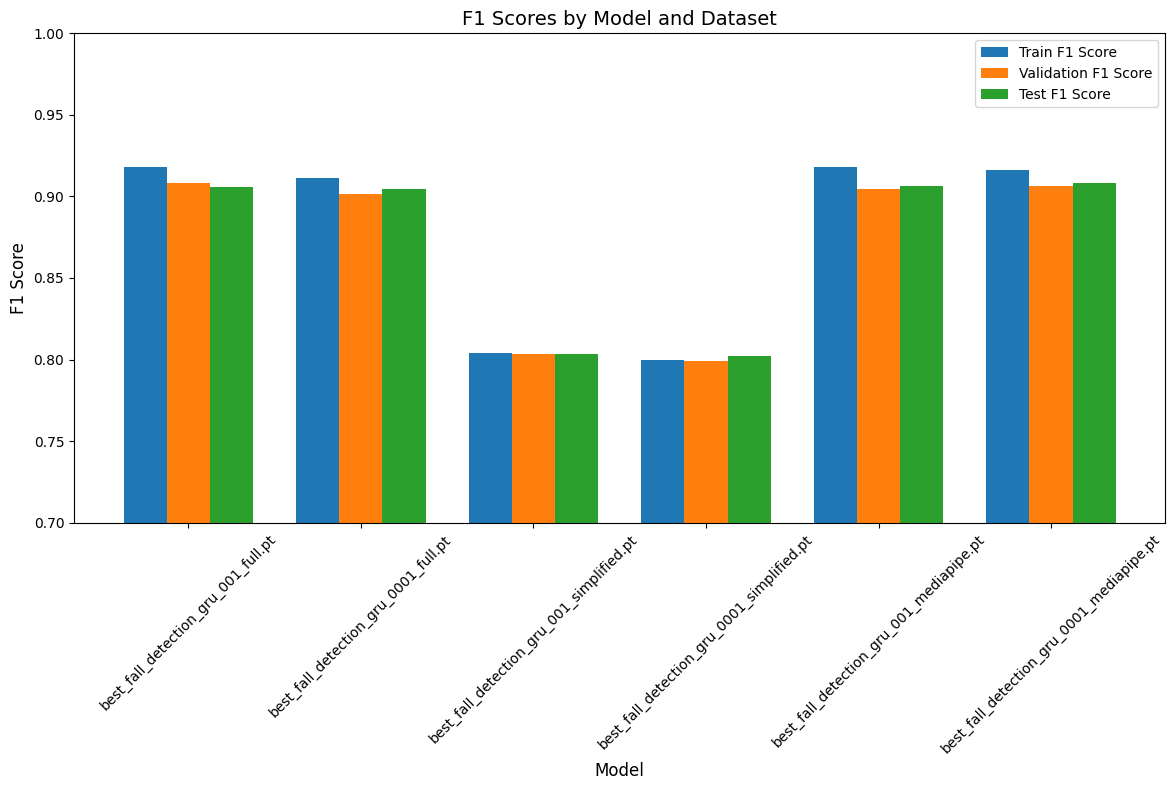

In [46]:
# 그래프용 데이터 변환
model_names = [result['Model'] for result in results]
train_scores = [result['Train'] for result in results]
val_scores = [result['Validation'] for result in results]
test_scores = [result['Test'] for result in results]

# 그래프 생성
plt.figure(figsize=(12, 8))
bar_width = 0.25
indices = range(len(model_names))

# 막대 그래프
plt.bar(indices, train_scores, bar_width, label="Train F1 Score")
plt.bar([i + bar_width for i in indices], val_scores, bar_width, label="Validation F1 Score")
plt.bar([i + 2 * bar_width for i in indices], test_scores, bar_width, label="Test F1 Score")

# 그래프 꾸미기
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("F1 Scores by Model and Dataset", fontsize=14)
plt.xticks([i + bar_width for i in indices], model_names, rotation=45, fontsize=10)
plt.ylim(0.7, 1.0)
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

In [4]:
# CNN 기반 낙상 감지 모델 정의
class FallDetectionCNN(nn.Module):
    def __init__(self, input_size, num_classes=3):
        super(FallDetectionCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=22, out_channels=64, kernel_size=3, padding=1)  # mediapipe dataset을 공유하므로 in_channels은 22
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.transpose(1, 2)  # Conv1d의 형태를 맞추기 위함 (batch_size, channels, length)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # tensor flattening
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# 모델 준비
def create_cnn_model_for_dataset(dataset):
    if len(dataset) > 0:
        sample_sequence, sample_label = dataset[0]
        input_size = len(sample_sequence)
        print(input_size)  # CNN에서는 시퀀스 길이를 input size로 사용
        return FallDetectionCNN(input_size=input_size).to(device)
    else:
        print("데이터 없음")
        exit()

# 학습 및 검증 설정
cnn_model_configs = [
    ('best_fall_detection_cnn_mediapipe_001.pt', 0.001),
    ('best_fall_detection_cnn_mediapipe_0001.pt', 0.0001)
]

# 학습 파라미터 설정
num_epochs = 500
patience = 20

In [13]:
for cnn_model_name, learning_rate in cnn_model_configs:
    # 모델 생성
    model = create_cnn_model_for_dataset(train_mediapipe_dataset)
    continue

3
3


In [ ]:
# 두 가지 학습률로 CNN 학습 진행
for cnn_model_name, learning_rate in cnn_model_configs:
    # 모델 생성
    model = create_cnn_model_for_dataset(train_mediapipe_dataset)
    model.to(device)

    # 손실 함수와 옵티마이저 정의
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # 각 학습 설정별 초기화
    best_loss = float('inf')
    no_improve = 0

    print(f"{cnn_model_name} 학습 시작 (lr={learning_rate})", flush=True)

    for epoch in range(num_epochs):
        model.train() # Training
        total_loss_train = 0

        for sequences, labels in tqdm(train_loader_mediapipe, desc=f"Epoch {epoch + 1}/{num_epochs} (lr={learning_rate})"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss_train = criterion(outputs, labels.view(-1))
            loss_train.backward()
            optimizer.step()

            total_loss_train += loss_train.item()

        avg_loss_train = total_loss_train / len(train_loader_mediapipe)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss (lr={learning_rate}): {avg_loss_train:.4f}')

        model.eval() # Validation
        total_loss_valid = 0
        with torch.no_grad():
            for sequences, labels in valid_loader_mediapipe:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss_valid = criterion(outputs, labels.view(-1))
                total_loss_valid += loss_valid.item()

        avg_loss_valid = total_loss_valid / len(valid_loader_mediapipe)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Valid Loss (lr={learning_rate}): {avg_loss_valid:.4f}')

        # 학습률 조정 스케줄러 업데이트
        scheduler.step(avg_loss_valid)

        # 최상의 모델 저장
        if avg_loss_valid < best_loss:
            best_loss = avg_loss_valid
            no_improve = 0
            torch.save(model.state_dict(), f'{pt_path}\\{cnn_model_name}')
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping")
            break

best_fall_detection_cnn_mediapipe_001.pt 학습 시작 (lr=0.001)


Epoch 1/500 (lr=0.001): 100%|██████████| 1608/1608 [00:03<00:00, 473.73it/s]


Epoch [1/500], Train Loss (lr=0.001): 0.5911
Epoch [1/500], Valid Loss (lr=0.001): 0.4900


Epoch 2/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 548.24it/s]


Epoch [2/500], Train Loss (lr=0.001): 0.4688
Epoch [2/500], Valid Loss (lr=0.001): 0.4677


Epoch 3/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 560.67it/s]


Epoch [3/500], Train Loss (lr=0.001): 0.4379
Epoch [3/500], Valid Loss (lr=0.001): 0.4270


Epoch 4/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 568.80it/s]


Epoch [4/500], Train Loss (lr=0.001): 0.4120
Epoch [4/500], Valid Loss (lr=0.001): 0.4183


Epoch 5/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 578.83it/s]


Epoch [5/500], Train Loss (lr=0.001): 0.3996
Epoch [5/500], Valid Loss (lr=0.001): 0.4089


Epoch 6/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 574.08it/s]


Epoch [6/500], Train Loss (lr=0.001): 0.3837
Epoch [6/500], Valid Loss (lr=0.001): 0.4139


Epoch 7/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 571.45it/s]


Epoch [7/500], Train Loss (lr=0.001): 0.3745
Epoch [7/500], Valid Loss (lr=0.001): 0.3896


Epoch 8/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 573.26it/s]


Epoch [8/500], Train Loss (lr=0.001): 0.3650
Epoch [8/500], Valid Loss (lr=0.001): 0.3934


Epoch 9/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 569.36it/s]


Epoch [9/500], Train Loss (lr=0.001): 0.3531
Epoch [9/500], Valid Loss (lr=0.001): 0.3670


Epoch 10/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 569.97it/s]


Epoch [10/500], Train Loss (lr=0.001): 0.3446
Epoch [10/500], Valid Loss (lr=0.001): 0.3561


Epoch 11/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 573.99it/s]


Epoch [11/500], Train Loss (lr=0.001): 0.3373
Epoch [11/500], Valid Loss (lr=0.001): 0.3936


Epoch 12/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 574.05it/s]


Epoch [12/500], Train Loss (lr=0.001): 0.3253
Epoch [12/500], Valid Loss (lr=0.001): 0.3767


Epoch 13/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 573.26it/s]


Epoch [13/500], Train Loss (lr=0.001): 0.3213
Epoch [13/500], Valid Loss (lr=0.001): 0.3672


Epoch 14/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 570.35it/s]


Epoch [14/500], Train Loss (lr=0.001): 0.3113
Epoch [14/500], Valid Loss (lr=0.001): 0.3544


Epoch 15/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 575.42it/s]


Epoch [15/500], Train Loss (lr=0.001): 0.3049
Epoch [15/500], Valid Loss (lr=0.001): 0.3779


Epoch 16/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 574.80it/s]


Epoch [16/500], Train Loss (lr=0.001): 0.2996
Epoch [16/500], Valid Loss (lr=0.001): 0.3698


Epoch 17/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 573.16it/s]


Epoch [17/500], Train Loss (lr=0.001): 0.2911
Epoch [17/500], Valid Loss (lr=0.001): 0.4018


Epoch 18/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 570.29it/s]


Epoch [18/500], Train Loss (lr=0.001): 0.2896
Epoch [18/500], Valid Loss (lr=0.001): 0.3467


Epoch 19/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 566.99it/s]


Epoch [19/500], Train Loss (lr=0.001): 0.2821
Epoch [19/500], Valid Loss (lr=0.001): 0.3580


Epoch 20/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 569.20it/s]


Epoch [20/500], Train Loss (lr=0.001): 0.2752
Epoch [20/500], Valid Loss (lr=0.001): 0.3621


Epoch 21/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 571.02it/s]


Epoch [21/500], Train Loss (lr=0.001): 0.2671
Epoch [21/500], Valid Loss (lr=0.001): 0.3609


Epoch 22/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 577.79it/s]


Epoch [22/500], Train Loss (lr=0.001): 0.2617
Epoch [22/500], Valid Loss (lr=0.001): 0.3756


Epoch 23/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 572.65it/s]


Epoch [23/500], Train Loss (lr=0.001): 0.2554
Epoch [23/500], Valid Loss (lr=0.001): 0.3878


Epoch 24/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 578.83it/s]


Epoch [24/500], Train Loss (lr=0.001): 0.2532
Epoch [24/500], Valid Loss (lr=0.001): 0.3729


Epoch 25/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 581.34it/s]


Epoch [25/500], Train Loss (lr=0.001): 0.1976
Epoch [25/500], Valid Loss (lr=0.001): 0.3755


Epoch 26/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 575.73it/s]


Epoch [26/500], Train Loss (lr=0.001): 0.1680
Epoch [26/500], Valid Loss (lr=0.001): 0.4227


Epoch 27/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 574.69it/s]


Epoch [27/500], Train Loss (lr=0.001): 0.1570
Epoch [27/500], Valid Loss (lr=0.001): 0.4367


Epoch 28/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 567.39it/s]


Epoch [28/500], Train Loss (lr=0.001): 0.1499
Epoch [28/500], Valid Loss (lr=0.001): 0.4401


Epoch 29/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 570.54it/s]


Epoch [29/500], Train Loss (lr=0.001): 0.1445
Epoch [29/500], Valid Loss (lr=0.001): 0.4807


Epoch 30/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 569.00it/s]


Epoch [30/500], Train Loss (lr=0.001): 0.1375
Epoch [30/500], Valid Loss (lr=0.001): 0.4998


Epoch 31/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 570.61it/s]


Epoch [31/500], Train Loss (lr=0.001): 0.1269
Epoch [31/500], Valid Loss (lr=0.001): 0.5136


Epoch 32/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 577.63it/s]


Epoch [32/500], Train Loss (lr=0.001): 0.1244
Epoch [32/500], Valid Loss (lr=0.001): 0.5261


Epoch 33/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 576.69it/s]


Epoch [33/500], Train Loss (lr=0.001): 0.1229
Epoch [33/500], Valid Loss (lr=0.001): 0.5294


Epoch 34/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 557.87it/s]


Epoch [34/500], Train Loss (lr=0.001): 0.1218
Epoch [34/500], Valid Loss (lr=0.001): 0.5400


Epoch 35/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 567.91it/s]


Epoch [35/500], Train Loss (lr=0.001): 0.1218
Epoch [35/500], Valid Loss (lr=0.001): 0.5411


Epoch 36/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 565.14it/s]


Epoch [36/500], Train Loss (lr=0.001): 0.1203
Epoch [36/500], Valid Loss (lr=0.001): 0.5485


Epoch 37/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 560.16it/s]


Epoch [37/500], Train Loss (lr=0.001): 0.1197
Epoch [37/500], Valid Loss (lr=0.001): 0.5497


Epoch 38/500 (lr=0.001): 100%|██████████| 1608/1608 [00:02<00:00, 559.50it/s]


Epoch [38/500], Train Loss (lr=0.001): 0.1193
Epoch [38/500], Valid Loss (lr=0.001): 0.5504
Early stopping
best_fall_detection_cnn_mediapipe_0001.pt 학습 시작 (lr=0.0001)


Epoch 1/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 568.62it/s]


Epoch [1/500], Train Loss (lr=0.0001): 0.7369
Epoch [1/500], Valid Loss (lr=0.0001): 0.5648


Epoch 2/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 563.82it/s]


Epoch [2/500], Train Loss (lr=0.0001): 0.5279
Epoch [2/500], Valid Loss (lr=0.0001): 0.4879


Epoch 3/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 564.44it/s]


Epoch [3/500], Train Loss (lr=0.0001): 0.4754
Epoch [3/500], Valid Loss (lr=0.0001): 0.4604


Epoch 4/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 567.00it/s]


Epoch [4/500], Train Loss (lr=0.0001): 0.4535
Epoch [4/500], Valid Loss (lr=0.0001): 0.4564


Epoch 5/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 565.00it/s]


Epoch [5/500], Train Loss (lr=0.0001): 0.4377
Epoch [5/500], Valid Loss (lr=0.0001): 0.4475


Epoch 6/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 566.60it/s]


Epoch [6/500], Train Loss (lr=0.0001): 0.4269
Epoch [6/500], Valid Loss (lr=0.0001): 0.4338


Epoch 7/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 571.43it/s]


Epoch [7/500], Train Loss (lr=0.0001): 0.4113
Epoch [7/500], Valid Loss (lr=0.0001): 0.4202


Epoch 8/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 576.55it/s]


Epoch [8/500], Train Loss (lr=0.0001): 0.3984
Epoch [8/500], Valid Loss (lr=0.0001): 0.4222


Epoch 9/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 568.97it/s]


Epoch [9/500], Train Loss (lr=0.0001): 0.3910
Epoch [9/500], Valid Loss (lr=0.0001): 0.4025


Epoch 10/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 572.79it/s]


Epoch [10/500], Train Loss (lr=0.0001): 0.3833
Epoch [10/500], Valid Loss (lr=0.0001): 0.4096


Epoch 11/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 569.82it/s]


Epoch [11/500], Train Loss (lr=0.0001): 0.3700
Epoch [11/500], Valid Loss (lr=0.0001): 0.4007


Epoch 12/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 569.33it/s]


Epoch [12/500], Train Loss (lr=0.0001): 0.3646
Epoch [12/500], Valid Loss (lr=0.0001): 0.3769


Epoch 13/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 572.14it/s]


Epoch [13/500], Train Loss (lr=0.0001): 0.3580
Epoch [13/500], Valid Loss (lr=0.0001): 0.3765


Epoch 14/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 573.87it/s]


Epoch [14/500], Train Loss (lr=0.0001): 0.3509
Epoch [14/500], Valid Loss (lr=0.0001): 0.3723


Epoch 15/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 546.36it/s]


Epoch [15/500], Train Loss (lr=0.0001): 0.3454
Epoch [15/500], Valid Loss (lr=0.0001): 0.3839


Epoch 16/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 561.74it/s]


Epoch [16/500], Train Loss (lr=0.0001): 0.3390
Epoch [16/500], Valid Loss (lr=0.0001): 0.3673


Epoch 17/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 568.93it/s]


Epoch [17/500], Train Loss (lr=0.0001): 0.3321
Epoch [17/500], Valid Loss (lr=0.0001): 0.4140


Epoch 18/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 564.31it/s]


Epoch [18/500], Train Loss (lr=0.0001): 0.3231
Epoch [18/500], Valid Loss (lr=0.0001): 0.3901


Epoch 19/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 568.90it/s]


Epoch [19/500], Train Loss (lr=0.0001): 0.3166
Epoch [19/500], Valid Loss (lr=0.0001): 0.3668


Epoch 20/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 571.93it/s]


Epoch [20/500], Train Loss (lr=0.0001): 0.3104
Epoch [20/500], Valid Loss (lr=0.0001): 0.3455


Epoch 21/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 559.34it/s]


Epoch [21/500], Train Loss (lr=0.0001): 0.3050
Epoch [21/500], Valid Loss (lr=0.0001): 0.3623


Epoch 22/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 569.80it/s]


Epoch [22/500], Train Loss (lr=0.0001): 0.3012
Epoch [22/500], Valid Loss (lr=0.0001): 0.3706


Epoch 23/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 572.13it/s]


Epoch [23/500], Train Loss (lr=0.0001): 0.2947
Epoch [23/500], Valid Loss (lr=0.0001): 0.3435


Epoch 24/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 559.82it/s]


Epoch [24/500], Train Loss (lr=0.0001): 0.2889
Epoch [24/500], Valid Loss (lr=0.0001): 0.3431


Epoch 25/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:03<00:00, 531.75it/s]


Epoch [25/500], Train Loss (lr=0.0001): 0.2835
Epoch [25/500], Valid Loss (lr=0.0001): 0.3362


Epoch 26/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:03<00:00, 533.87it/s]


Epoch [26/500], Train Loss (lr=0.0001): 0.2775
Epoch [26/500], Valid Loss (lr=0.0001): 0.3325


Epoch 27/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 548.06it/s]


Epoch [27/500], Train Loss (lr=0.0001): 0.2718
Epoch [27/500], Valid Loss (lr=0.0001): 0.3284


Epoch 28/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 545.83it/s]


Epoch [28/500], Train Loss (lr=0.0001): 0.2654
Epoch [28/500], Valid Loss (lr=0.0001): 0.3452


Epoch 29/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 569.40it/s]


Epoch [29/500], Train Loss (lr=0.0001): 0.2635
Epoch [29/500], Valid Loss (lr=0.0001): 0.3563


Epoch 30/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 568.00it/s]


Epoch [30/500], Train Loss (lr=0.0001): 0.2571
Epoch [30/500], Valid Loss (lr=0.0001): 0.3451


Epoch 31/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 576.34it/s]


Epoch [31/500], Train Loss (lr=0.0001): 0.2505
Epoch [31/500], Valid Loss (lr=0.0001): 0.3361


Epoch 32/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 573.97it/s]


Epoch [32/500], Train Loss (lr=0.0001): 0.2448
Epoch [32/500], Valid Loss (lr=0.0001): 0.3233


Epoch 33/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 575.51it/s]


Epoch [33/500], Train Loss (lr=0.0001): 0.2400
Epoch [33/500], Valid Loss (lr=0.0001): 0.3210


Epoch 34/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 540.79it/s]


Epoch [34/500], Train Loss (lr=0.0001): 0.2334
Epoch [34/500], Valid Loss (lr=0.0001): 0.3310


Epoch 35/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 566.20it/s]


Epoch [35/500], Train Loss (lr=0.0001): 0.2329
Epoch [35/500], Valid Loss (lr=0.0001): 0.3304


Epoch 36/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 578.21it/s]


Epoch [36/500], Train Loss (lr=0.0001): 0.2255
Epoch [36/500], Valid Loss (lr=0.0001): 0.3217


Epoch 37/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 566.60it/s]


Epoch [37/500], Train Loss (lr=0.0001): 0.2203
Epoch [37/500], Valid Loss (lr=0.0001): 0.3745


Epoch 38/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 582.61it/s]


Epoch [38/500], Train Loss (lr=0.0001): 0.2155
Epoch [38/500], Valid Loss (lr=0.0001): 0.3788


Epoch 39/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:03<00:00, 524.98it/s]


Epoch [39/500], Train Loss (lr=0.0001): 0.2120
Epoch [39/500], Valid Loss (lr=0.0001): 0.3306


Epoch 40/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 542.83it/s]


Epoch [40/500], Train Loss (lr=0.0001): 0.1746
Epoch [40/500], Valid Loss (lr=0.0001): 0.3229


Epoch 41/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 560.83it/s]


Epoch [41/500], Train Loss (lr=0.0001): 0.1662
Epoch [41/500], Valid Loss (lr=0.0001): 0.3237


Epoch 42/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 564.80it/s]


Epoch [42/500], Train Loss (lr=0.0001): 0.1635
Epoch [42/500], Valid Loss (lr=0.0001): 0.3222


Epoch 43/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 568.51it/s]


Epoch [43/500], Train Loss (lr=0.0001): 0.1614
Epoch [43/500], Valid Loss (lr=0.0001): 0.3216


Epoch 44/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 585.36it/s]


Epoch [44/500], Train Loss (lr=0.0001): 0.1597
Epoch [44/500], Valid Loss (lr=0.0001): 0.3288


Epoch 45/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 576.34it/s]


Epoch [45/500], Train Loss (lr=0.0001): 0.1572
Epoch [45/500], Valid Loss (lr=0.0001): 0.3329


Epoch 46/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 584.94it/s]


Epoch [46/500], Train Loss (lr=0.0001): 0.1525
Epoch [46/500], Valid Loss (lr=0.0001): 0.3294


Epoch 47/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 581.76it/s]


Epoch [47/500], Train Loss (lr=0.0001): 0.1524
Epoch [47/500], Valid Loss (lr=0.0001): 0.3296


Epoch 48/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 579.66it/s]


Epoch [48/500], Train Loss (lr=0.0001): 0.1525
Epoch [48/500], Valid Loss (lr=0.0001): 0.3307


Epoch 49/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 573.67it/s]


Epoch [49/500], Train Loss (lr=0.0001): 0.1509
Epoch [49/500], Valid Loss (lr=0.0001): 0.3296


Epoch 50/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 576.55it/s]


Epoch [50/500], Train Loss (lr=0.0001): 0.1518
Epoch [50/500], Valid Loss (lr=0.0001): 0.3297


Epoch 51/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 580.50it/s]


Epoch [51/500], Train Loss (lr=0.0001): 0.1515
Epoch [51/500], Valid Loss (lr=0.0001): 0.3319


Epoch 52/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 568.39it/s]


Epoch [52/500], Train Loss (lr=0.0001): 0.1519
Epoch [52/500], Valid Loss (lr=0.0001): 0.3317


Epoch 53/500 (lr=0.0001): 100%|██████████| 1608/1608 [00:02<00:00, 550.87it/s]


Epoch [53/500], Train Loss (lr=0.0001): 0.1508
Epoch [53/500], Valid Loss (lr=0.0001): 0.3317
Early stopping


In [47]:
# 학습, 검증, 테스트 데이터셋 평가
results_2 = []
for cnn_model_name, _ in cnn_model_configs:
    # 모델 생성 (각 모델의 input에 맞게 dataset 전달)
    model = create_cnn_model_for_dataset(train_mediapipe_dataset)
    model.load_state_dict(torch.load(f'{pt_path}\\{cnn_model_name}', weights_only=True))
    model.to(device)

    # 데이터셋별 평가
    scores = {'Model': cnn_model_name}
    for loader_name, data_loader in [('Train', train_loader_mediapipe), ('Validation', valid_loader_mediapipe), ('Test', test_loader_mediapipe)]:
        f1, cm = calculate_metrics(model, data_loader)
        print(f"{cnn_model_name} ({loader_name}): F1 Score: {f1:.4f}")
        print(f"Confusion Matrix ({loader_name}):\n{cm}")
        scores[loader_name] = f1
    results_2.append(scores)

best_fall_detection_cnn_mediapipe_001.pt (Train): F1 Score: 0.9180
Confusion Matrix (Train):
[[26830  1759  1336]
 [  257  3220   243]
 [  243   612 16927]]
best_fall_detection_cnn_mediapipe_001.pt (Validation): F1 Score: 0.9057
Confusion Matrix (Validation):
[[3323  239  170]
 [  44  377   56]
 [  39   93 2087]]
best_fall_detection_cnn_mediapipe_001.pt (Test): F1 Score: 0.9055
Confusion Matrix (Test):
[[3349  257  176]
 [  46  366   60]
 [  32   70 2073]]
best_fall_detection_cnn_mediapipe_0001.pt (Train): F1 Score: 0.9362
Confusion Matrix (Train):
[[27768  1514   643]
 [  245  3331   144]
 [  323   610 16849]]
best_fall_detection_cnn_mediapipe_0001.pt (Validation): F1 Score: 0.9148
Confusion Matrix (Validation):
[[3396  235  101]
 [  40  388   49]
 [  60   98 2061]]
best_fall_detection_cnn_mediapipe_0001.pt (Test): F1 Score: 0.9167
Confusion Matrix (Test):
[[3438  250   94]
 [  42  374   56]
 [  48   81 2046]]


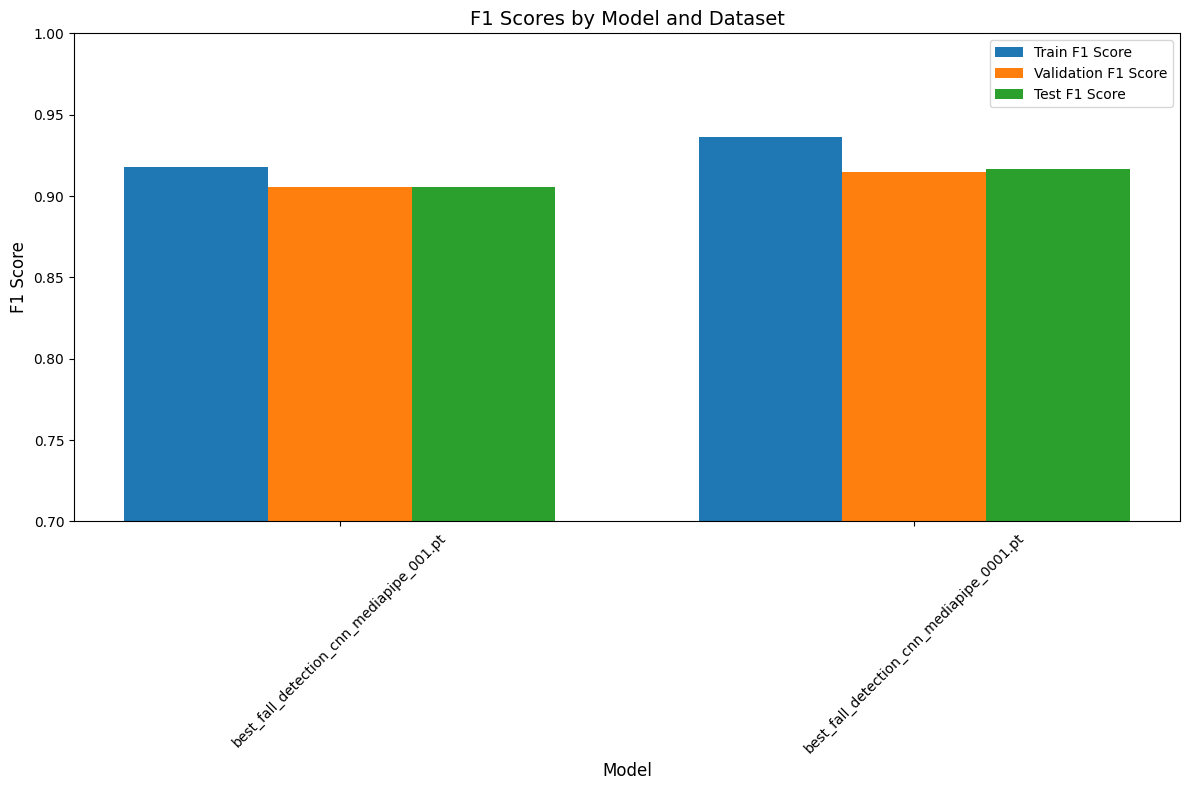

In [48]:
# 그래프용 데이터 변환
model_names = [result['Model'] for result in results_2]
train_scores = [result['Train'] for result in results_2]
val_scores = [result['Validation'] for result in results_2]
test_scores = [result['Test'] for result in results_2]

# 그래프 생성
plt.figure(figsize=(12, 8))
bar_width = 0.25
indices = range(len(model_names))

# 막대 그래프
plt.bar(indices, train_scores, bar_width, label="Train F1 Score")
plt.bar([i + bar_width for i in indices], val_scores, bar_width, label="Validation F1 Score")
plt.bar([i + 2 * bar_width for i in indices], test_scores, bar_width, label="Test F1 Score")

# 그래프 꾸미기
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("F1 Scores by Model and Dataset", fontsize=14)
plt.xticks([i + bar_width for i in indices], model_names, rotation=45, fontsize=10)
plt.ylim(0.7, 1.0)
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

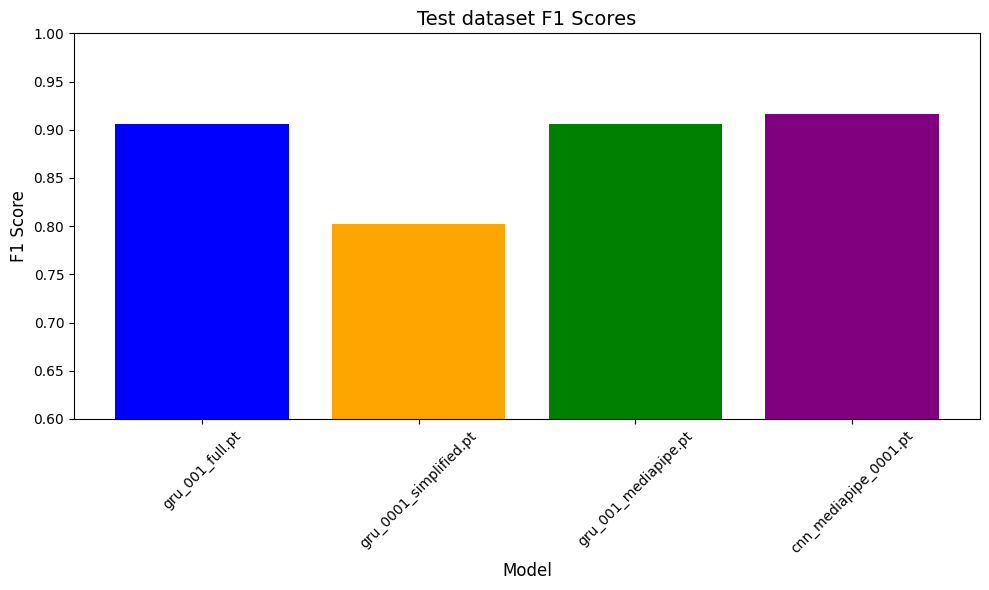

In [49]:
model_f1_scores = [
    ('best_fall_detection_gru_001_full.pt', 0.9059),
    ('best_fall_detection_gru_0001_simplified.pt', 0.8020),
    ('best_fall_detection_gru_001_mediapipe.pt', 0.9061),
    ('best_fall_detection_cnn_mediapipe_0001.pt', 0.9167)
]

# 모델명과 Test F1 Scores를 분리하여 리스트로 저장
model_names = [name.split('best_fall_detection_')[1] for name, _ in model_f1_scores]
train_f1_scores = [x[1] for x in model_f1_scores]

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(model_names, train_f1_scores, color=['blue', 'orange', 'green', 'purple'])

# 그래프 꾸미기
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.title("Test dataset F1 Scores", fontsize=14)
plt.ylim(0.6, 1.0)

# x축 라벨의 가독성을 위해 회전 추가
plt.xticks(rotation=45, fontsize=10)

# 그래프 출력
plt.tight_layout()
plt.show()